This script explores the effect of temperature threshold exceedances on global GDP.

Key research questions we look at are 
 - What is a good model for relating GDP to metrics describing GMT? 
 - What is the marginial effect of cumulative exceedane depth & global GDP? 
 - What is the marginial effect of cumulative exceedane depth on country-level GDP? 

The goal of this script is to use the model found in 001_model_selection.ipynb to look at the marginal effect of cumulative exceedance depth on global & country-level GDP.  

In [2]:
import sys
sys.path.append('/Users/schoens/Documents/Projekte/Econ/Code/v3/')

import numpy as np
import pandas as pd 
import xarray as xr
import statsmodels.api as sm

from pathlib import Path
import config.settings as cset

import matplotlib.pyplot as plt
import seaborn as sns

#### Loading & Preparing Data

In [15]:

# load parameter
thrshld        = 1.5
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_max', 'gmt_max tas_baseline']
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline',  'gmt_uxc', 'gmt_uxc tas_baseline', 'tas_soc', 'tas_soc^2', 'gmt_max', 'gmt_max tas_baseline', 'gmt_soc', 'gmt_soc tas_baseline']
# # sel_predictors = ['gmt_exc', 'gmt_exc^2', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc^2', 'gmt_uxc tas_baseline', 'tas_soc^2', 'tas_soc', 'gmt_max', 'gmt_max tas_baseline']
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'gmt_max', 'gmt_max tas_baseline', 'gmt_max^2', 'tas_soc', 'tas_soc^2', 'gmt_soc tas_baseline', 'gmt_soc^2']
# sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'gmt_max', 'gmt_max tas_baseline', 'gmt_max^2', 'tas_soc', 'tas_soc^2']
sel_predictors = ['gmt_exc', 'gmt_exc tas_baseline', 'gmt_uxc', 'gmt_uxc tas_baseline', 'gmt_max', 'gmt_max tas_baseline', 'tas_soc', 'tas_baseline tas_soc']

# load data 
regression_df  = pd.read_csv(Path.joinpath(cset.path_CHAR_results, 'regression_dataset.csv'), index_col = 0)

# prepare data for regression analysis
#    - allowing for country fixed effects
n_countries = int(len(regression_df)/1000)
X_intercept = np.zeros((len(regression_df), n_countries))
for i in range(n_countries):
    X_intercept[i*1000:(i+1)*1000, i] = 1
    
unique_models      = np.unique(regression_df['model_id'].values)
n_models           = len(unique_models)
X_model_correction = np.zeros((len(regression_df), n_models))
for i in range(n_models):   
    model_id = unique_models[i]
    X_model_correction[regression_df['model_id'] == model_id, i] = 1
    
#     - creating predictor matrix (standardizing model output does not alter results --> omitted for interpretability)
X  = np.c_[regression_df[sel_predictors], X_intercept, X_model_correction]
#     - creating target variable 
y  = regression_df['log_diff_SSP2'].values  

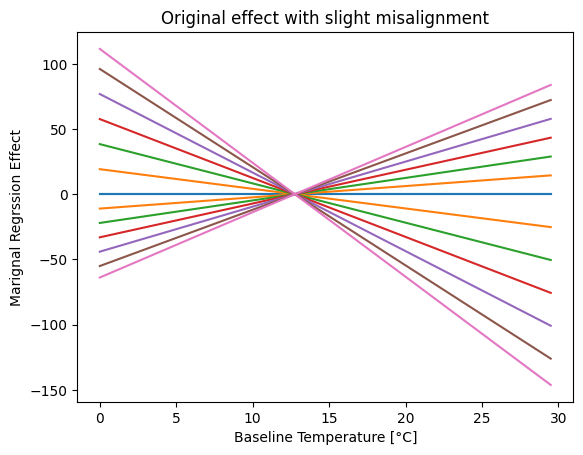

In [16]:
x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

# - ordinary regression wihtout intriducing constraints: 
country_model  = sm.OLS(endog = y, exog = X).fit()
from scipy.optimize import curve_fit

def objective_function(x, *a):
    b2    = a[2]/a[0]*a[1]
    a_adj = np.append(a[:3], np.append([b2], a[3:]))
    return(a_adj@x)

popt, pcov = curve_fit(objective_function, 
                       X.T,
                       y,
                       p0 = np.append(country_model.params[:3], 
                                      country_model.params[4:]))

results_country_params = np.append(popt[:3], np.append([popt[2]/popt[0]*popt[1]], popt[3:]))
country_model.params   = results_country_params
plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,145]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
# plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Original effect with slight misalignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

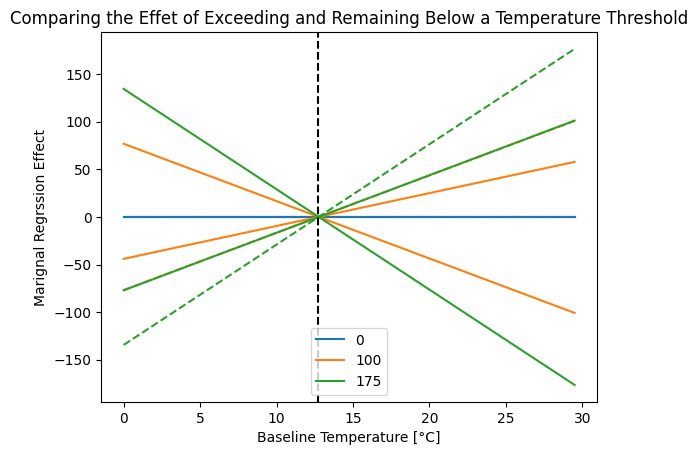

In [17]:
x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,100,175]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + +country_model.params[0]*x_E, color = sns.color_palette()[i_color], label = x_E)
    plt.plot(x_Ts, -(country_model.params[1]*x_Ts*x_E + +country_model.params[0]*x_E), color = sns.color_palette()[i_color], linestyle = '--')
    plt.plot(x_Ts,  country_model.params[3]*x_Ts*x_E + +country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Comparing the Effet of Exceeding and Remaining Below a Temperature Threshold')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.legend()
plt.show()


#### Fitting Regression Model

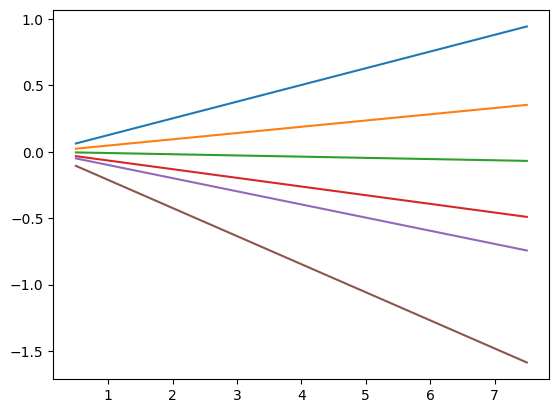

In [18]:
plt.figure()
for x_T in [0,7,12, 17, 20, 30]:
    plt.plot(np.arange(0.5,8,0.5),  country_model.params[4]*np.arange(0.5,8,0.5) + country_model.params[5]*x_T*np.arange(0.5,8,0.5) )
plt.show()

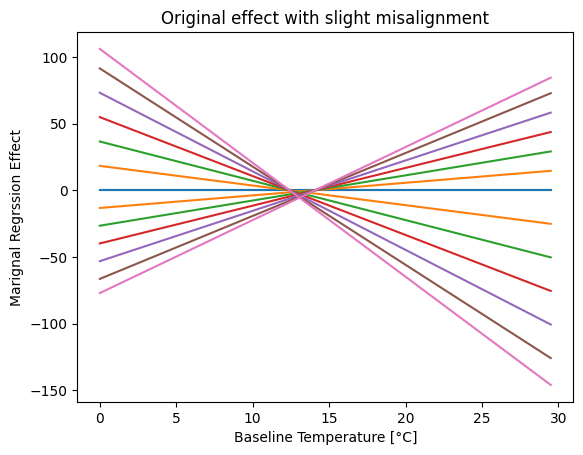

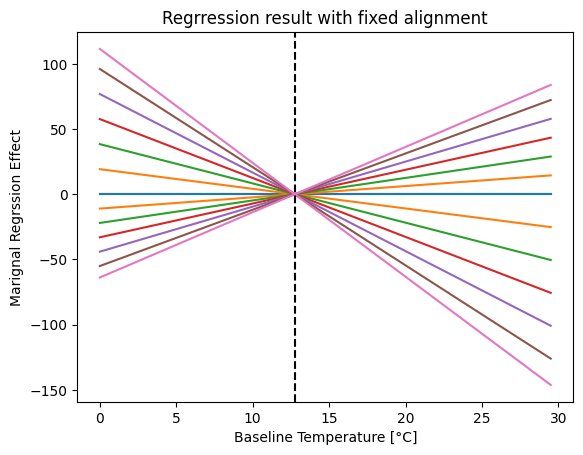

In [8]:
# effects from x_exc and x_uxc should have the same zero-crossing for keeping validaty 
# if the effects would not have the same zero-crossing, exceeding a temperature threshold could lead 
# to an increase(decrease) in GDP while remaining below a temperature threshold would have the same effect i .e. 
# also lead to a decrease(increase) in GDP, which is physically implausible; the results from the ordinary regression are already 
# well aligned, but just slightly off 
x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

# - ordinary regression wihtout intriducing constraints: 
country_model  = sm.OLS(endog = y, exog = X).fit()
plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,145]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
# plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Original effect with slight misalignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

# - introducing a constrained regression model: 
from scipy.optimize import curve_fit

def objective_function(x, *a):
    b2    = a[2]/a[0]*a[1]
    a_adj = np.append(a[:3], np.append([b2], a[3:]))
    return(a_adj@x)

popt, pcov = curve_fit(objective_function, 
                       X.T,
                       y,
                       p0 = np.append(country_model.params[:3], 
                                      country_model.params[4:]))

results_country_params = np.append(popt[:3], np.append([popt[2]/popt[0]*popt[1]], popt[3:]))
country_model.params   = results_country_params

x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,25,50,75,100,125,145]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color])
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
plt.axvline(x = 12.8, color = 'black', linestyle = '--')
plt.title('Regrression result with fixed alignment')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

# fitting a global model (only approximates averages)
sel_global_predictors  = [predictor for predictor in sel_predictors if not 'tas_baseline' in predictor]
X_global               = np.c_[regression_df[sel_global_predictors], X_intercept]
y                      = regression_df['log_diff_SSP2'].values  
global_model           = sm.OLS(endog = y, exog = X_global).fit()

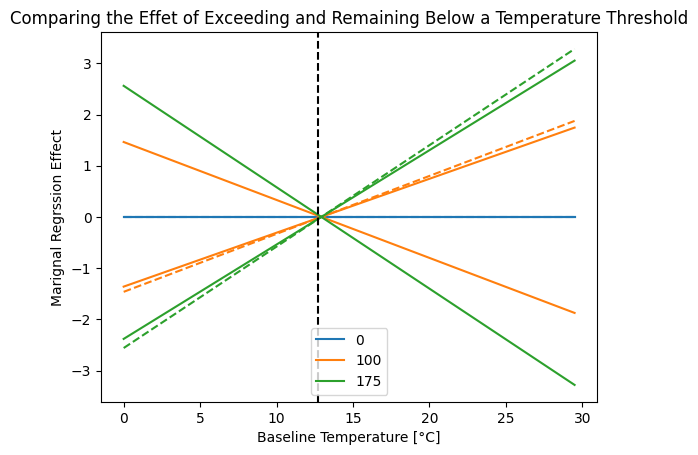

In [69]:
x_EXC = np.arange(0,145,1)
x_Ts  = np.arange(0,30,0.5) 

plt.figure()
i_color = 0
for x_E in [0,100,175]:
    plt.plot(x_Ts, country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E, color = sns.color_palette()[i_color], label = x_E)
    plt.plot(x_Ts, -(country_model.params[1]*x_Ts*x_E + country_model.params[0]*x_E), color = sns.color_palette()[i_color], linestyle = '--')
    plt.plot(x_Ts, country_model.params[3]*x_Ts*x_E + country_model.params[2]*x_E, color = sns.color_palette()[i_color])
    i_color += 1
plt.axvline(x = 12.7, color = 'black', linestyle = '--')
plt.title('Comparing the Effet of Exceeding and Remaining Below a Temperature Threshold')
plt.xlabel('Baseline Temperature [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.legend()
plt.show()

# Exceeding a temperature threshold has slightly larger effects than remaining below 

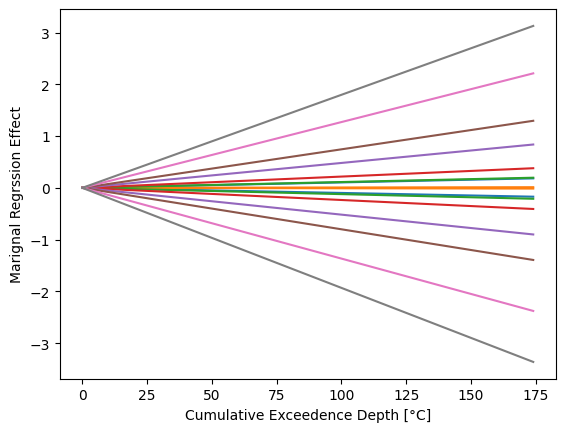

In [70]:
x_EXC = np.arange(0,175,1)

plt.figure()
i_color = 0
for x_T in [12,13,14,15,17.5,20,25,30]:
    plt.plot(x_EXC, country_model.params[1]*x_EXC*x_T + country_model.params[0]*x_EXC, color = sns.color_palette()[i_color])
    plt.plot(x_EXC, country_model.params[3]*x_EXC*x_T + country_model.params[2]*x_EXC, color = sns.color_palette()[i_color])
    i_color += 1
plt.xlabel('Cumulative Exceedence Depth [°C]')
plt.ylabel('Marignal Regrssion Effect')
plt.show()

In [19]:
import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection

import numpy as np
import matplotlib
from matplotlib import colormaps as cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.collections import LineCollection
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

def multiline(xs, ys, c, ax=None, **kwargs):
    """Plot lines with different colorings

    Parameters
    ----------
    xs : iterable container of x coordinates
    ys : iterable container of y coordinates
    c : iterable container of numbers mapped to colormap
    ax (optional): Axes to plot on.
    kwargs (optional): passed to LineCollection

    Notes:
        len(xs) == len(ys) == len(c) is the number of line segments
        len(xs[i]) == len(ys[i]) is the number of points for each line (indexed by i)

    Returns
    -------
    lc : LineCollection instance.
    """

    # find axes
    ax = plt.gca() if ax is None else ax

    # create LineCollection
    segments = [np.column_stack([x, y]) for x, y in zip(xs, ys)]
    lc = LineCollection(segments, **kwargs)

    # set coloring of line segments
    #    Note: I get an error if I pass c as a list here... not sure why.
    lc.set_array(np.asarray(c))

    # add lines to axes and rescale 
    #    Note: adding a collection doesn't autoscalee xlim/ylim
    ax.add_collection(lc)
    ax.autoscale()
    return lc

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # plt.register_cmap(cmap=newcmap)

    return newcmap

# Generate colors from coolwarm colormap
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.colors import LinearSegmentedColormap

# Function to blend a color with grey
def dim_color(color, blend_factor=0.2):
    grey = np.array([0.5, 0.5, 0.5])
    return (1 - blend_factor) * np.array(to_rgb(color)) + blend_factor * grey

cmap = plt.get_cmap('coolwarm')
n_colors = cmap.N
colors = [cmap(i) for i in range(n_colors)]

# Dim the colors
dimmed_colors = [dim_color(color) for color in colors]

# Create a new colormap from the dimmed colors
dimmed_cmap = ListedColormap(dimmed_colors, name='dimmed_coolwarm')

orig_cmap    = cm.get_cmap('coolwarm')
# zero change at 12.44°C --> scale colormap such that it is centered around 12.44
dimmed_shifted_cmap   = shiftedColorMap(dimmed_cmap, start=0, midpoint = 0.1124, stop = 1)
coolwarm_shifted_cmap = shiftedColorMap(orig_cmap, start=0, midpoint = 0.1124, stop = 1)
sel_colormap = coolwarm_shifted_cmap

country_params = country_model.params
global_params  = global_model.params

def compute_marginal_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline)

def compute_marginal_effects_glboal(exc): 
    return(global_params[0]*exc)

def compute_marginal_undershoot_effects_country(exc, tas_baseline): 
    return(country_params[2]*exc + country_params[3]*exc*tas_baseline)

def compute_marginal_undershoot_effects_glboal(exc): 
    return(global_params[1]*exc)

def compute_marginal_eoc_effects_country(eoc, tas_baseline): 
    return(country_params[4]*eoc + country_params[5]*eoc*tas_baseline)

def compute_marginal_eoc_effects_glboal(eoc): 
    return(global_params[4]*eoc)

In [20]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,6))

focus_linestyles        = [ (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params

/var/folders/ct/sv7_xh9x0bn978n81q83b5tr0000gp/T/ipykernel_33699/1764508689.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(sel_colormap)


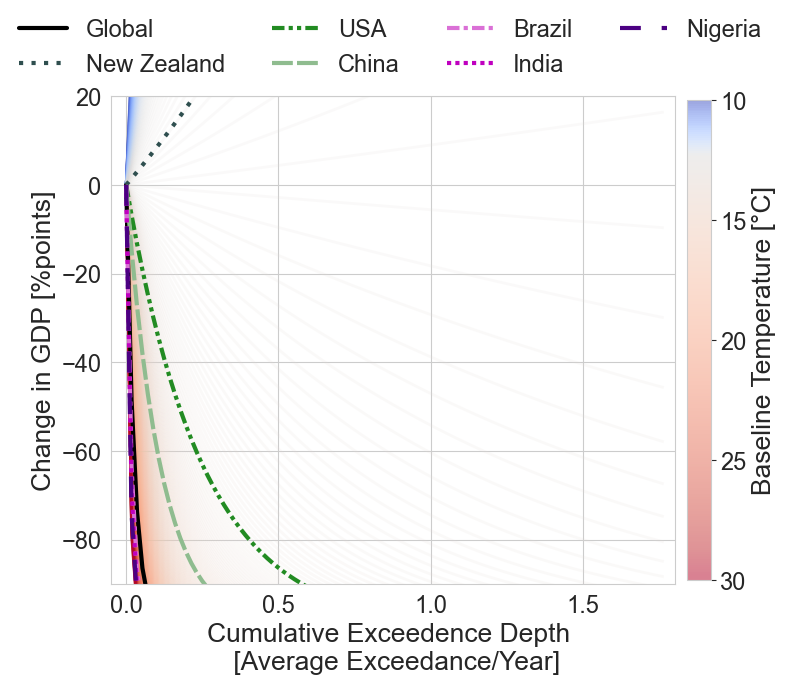

In [21]:
labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    cmap = plt.cm.get_cmap(sel_colormap)
    cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # axcb = fig.colorbar(lc)
    # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    ticks = [10, 15, 20, 25, 30]
    axcb.set_ticks(ticks)
    axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    plt.ylim(-90,20)
    plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

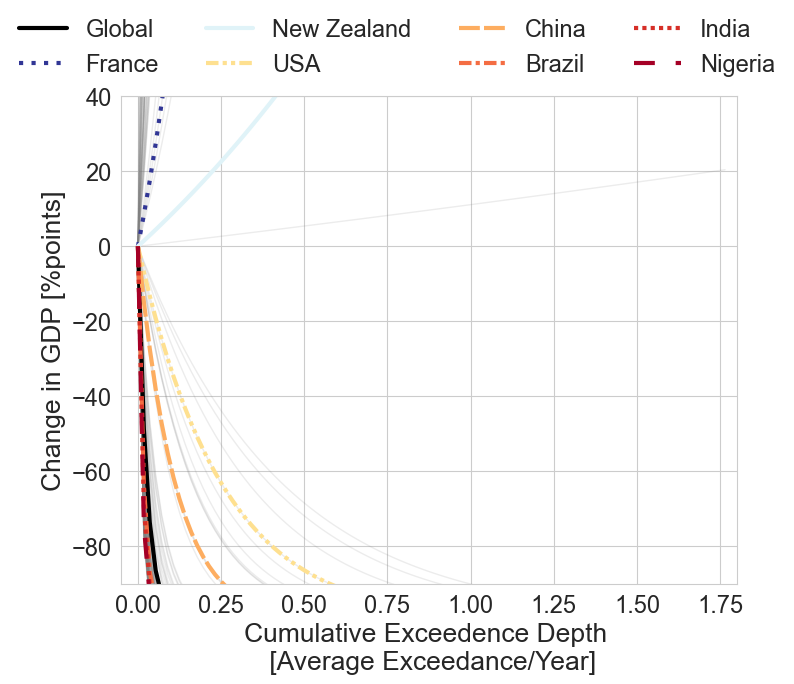

In [14]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    plt.ylim(-90,40)
    plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

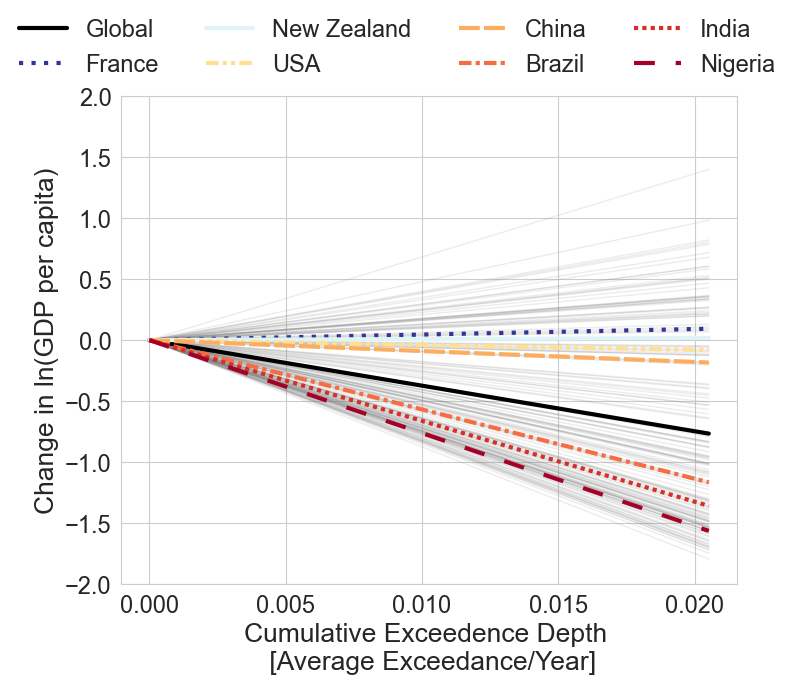

In [24]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)/86

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, y_synth, linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, y_synth, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, y_synth, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in ln(GDP per capita)', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    plt.ylim(-2,2)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

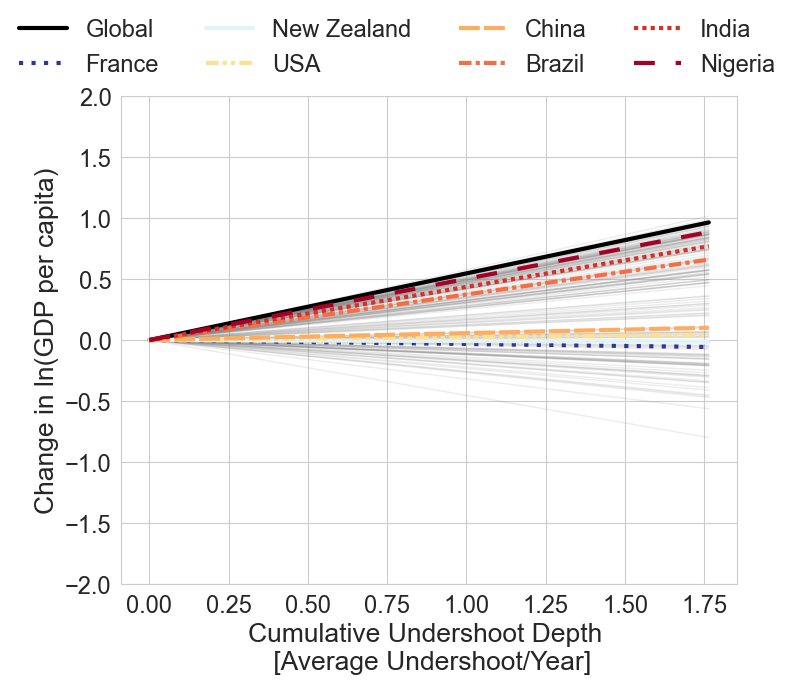

In [169]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_undershoot_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_undershoot_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, y_synth, linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_undershoot_effects_glboal(x_exc)
    ax.plot(x_exc/85, y_synth, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_undershoot_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, y_synth, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Undershoot Depth \n [Average Undershoot/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in ln(GDP per capita)', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    plt.ylim(-2,2)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

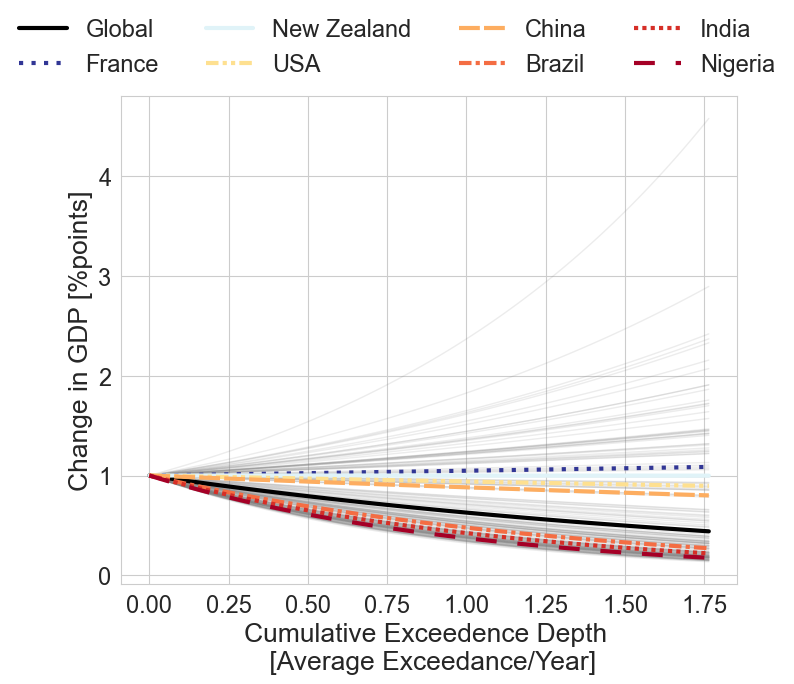

In [45]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, np.exp(y_synth), linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, np.exp(y_synth), label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, np.exp(y_synth), label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-90,40)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

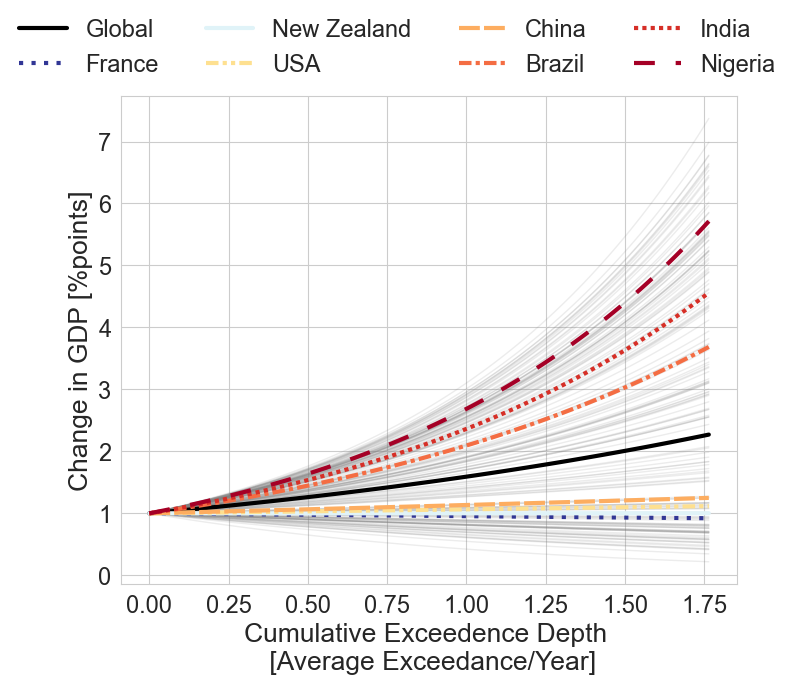

In [46]:
with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, 1/np.exp(y_synth), linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_effects_glboal(x_exc)
    ax.plot(x_exc/85, 1/np.exp(y_synth), label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, 1/np.exp(y_synth), label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-90,40)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

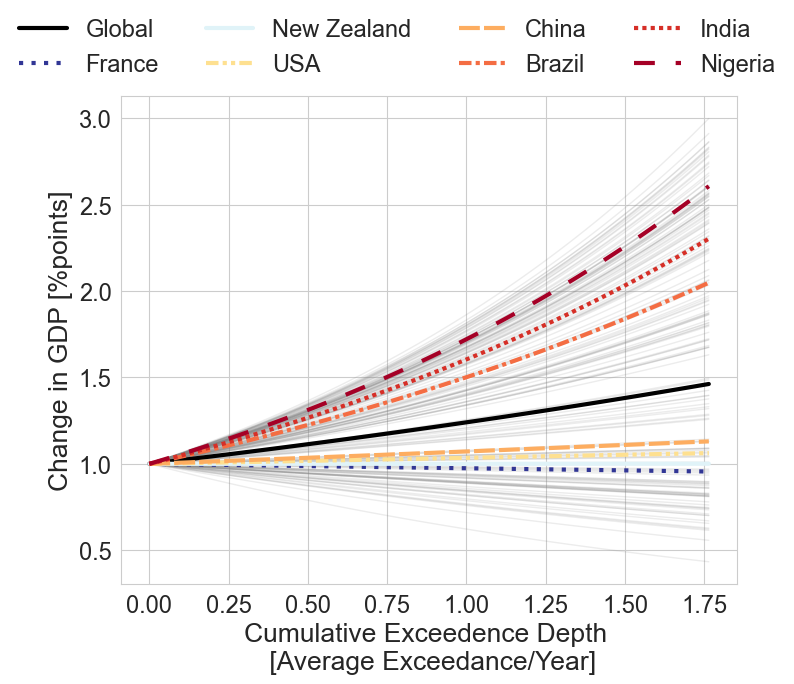

In [47]:
with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_undershoot_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, np.exp(y_synth), linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_undershoot_effects_glboal(x_exc)
    ax.plot(x_exc/85, np.exp(y_synth), label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_undershoot_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, np.exp(y_synth), label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Exceedence Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-90,40)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

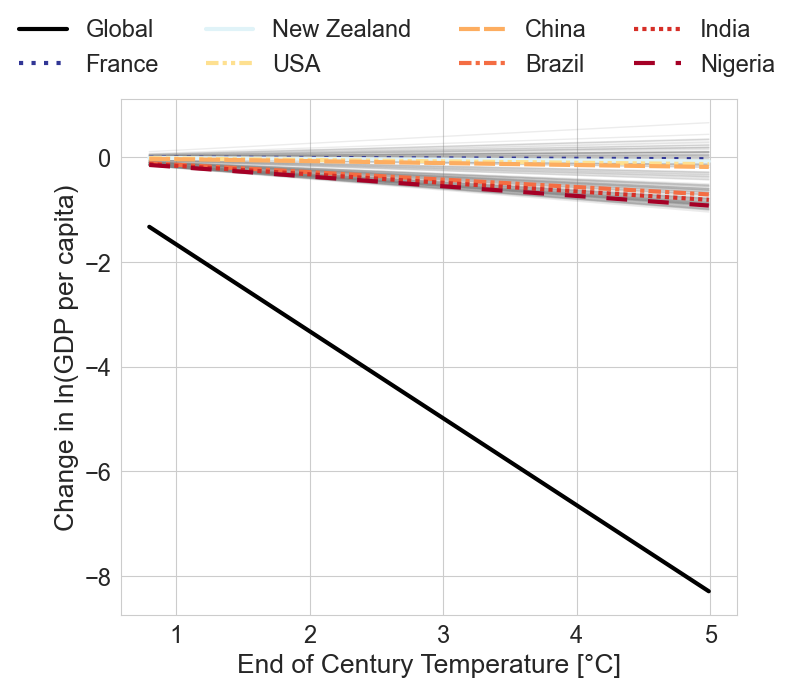

In [25]:
with sns.axes_style('whitegrid'):
    x_eoc = np.arange(0.8, 5, 0.01)
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_eoc_effects_country(x_eoc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_eoc, y_synth, linewidth = 1, color = 'grey', alpha = 0.15)
        
    y_synth = compute_marginal_eoc_effects_glboal(x_eoc)
    ax.plot(x_eoc, y_synth, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_eoc_effects_country(x_eoc, country_temp)
        ax.plot(x_eoc, y_synth, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('End of Century Temperature [°C]', fontsize = labelsize_large)
    ax.set_ylabel('Change in ln(GDP per capita)', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-90,40)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

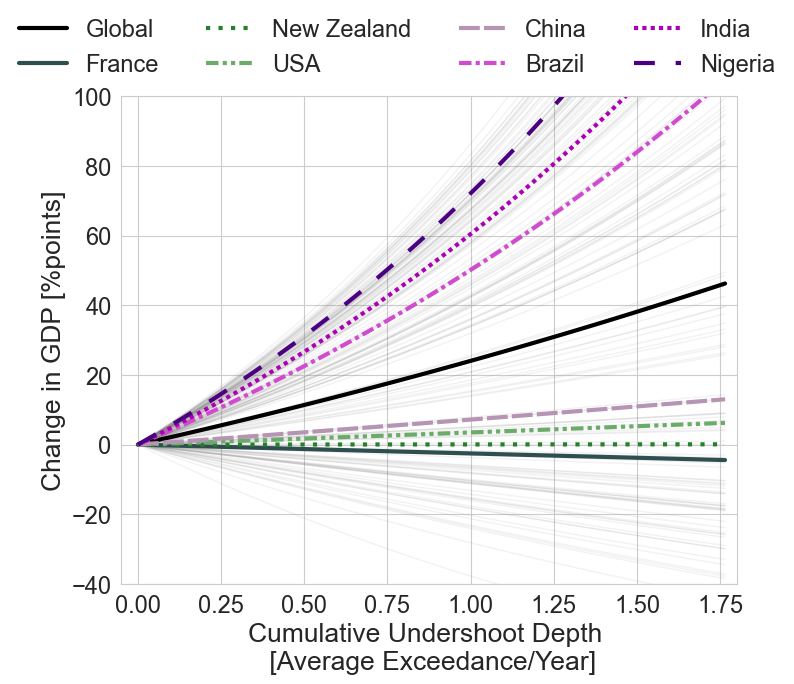

In [22]:
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))

focus_linestyles        = ['solid', (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_undershoot_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, linewidth = 1, color = 'grey', alpha = 0.1)
        
    y_synth = compute_marginal_undershoot_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_undershoot_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Undershoot Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    plt.ylim(-40,100)
    plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

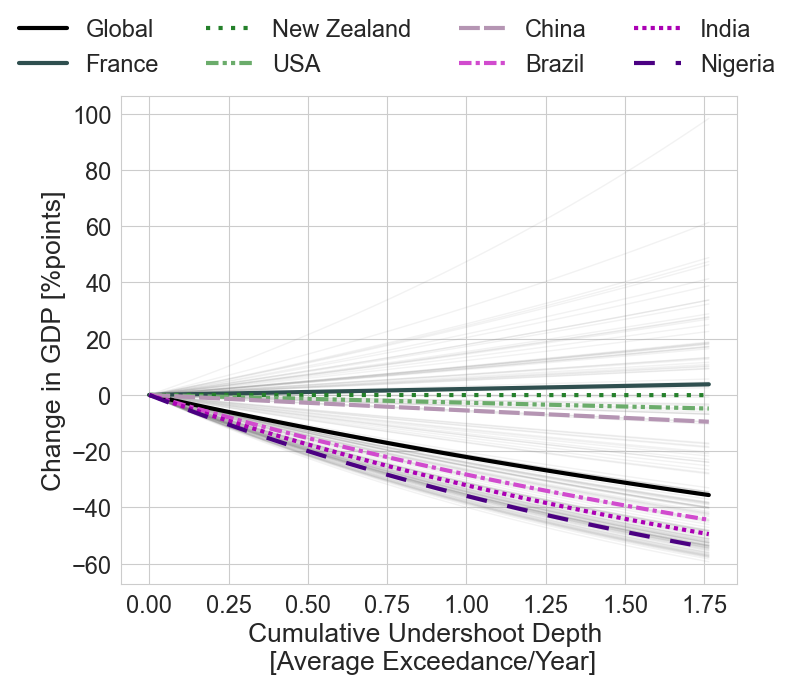

In [40]:
def compute_marginal_joint_effects_country(exc, tas_baseline): 
    return(country_params[0]*exc + country_params[1]*exc*tas_baseline+country_params[2]*exc + country_params[3]*exc*tas_baseline)

def compute_marginal_joint_effects_glboal(exc): 
    return(global_params[0]*exc+global_params[1]*exc)

# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))

focus_linestyles        = ['solid', (0,(1, 2)), (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        y_synth = compute_marginal_joint_effects_country(x_exc, sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, linewidth = 1, color = 'grey', alpha = 0.1)
        
    y_synth = compute_marginal_joint_effects_glboal(x_exc)
    ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        y_synth         = compute_marginal_joint_effects_country(x_exc, country_temp)
        ax.plot(x_exc/85, -(1-np.exp(y_synth))*100, label = country_name, linewidth = 3,  linestyle = focus_linestyles[i_country], color = focus_colours[i_country])
        
    axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Cumulative Undershoot Depth \n [Average Exceedance/Year]', fontsize = labelsize_large)
    ax.set_ylabel('Change in GDP [%points]', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-40,100)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

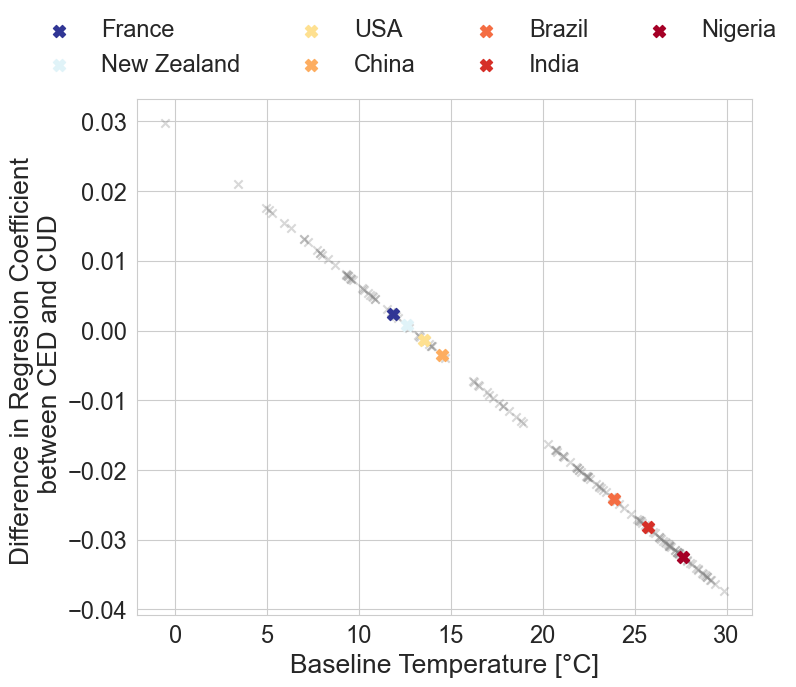

In [133]:
# plot showing ratios of marginal effects
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_undershoot_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    baselines = []
    ratios     = []
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        coeff_ced = country_model.params[0] + country_model.params[1]*sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0]
        coeff_cud = country_model.params[2] + country_model.params[3]*sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0]
        baselines.append(sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        ratios.append(coeff_ced-coeff_cud)
        
    ax.scatter(baselines, ratios, marker = 'x', color = 'grey', alpha = 0.3)
        
    # y_synth = compute_marginal_undershoot_effects_glboal(x_exc)
    # ax.plot(x_exc/85, y_synth, label = f'Global', color = 'black', linewidth = 3)
    
    for i_country in range(len(focus_countries)): 
        country_iso     = focus_countries[i_country]
        country_name    = focus_countries_names[i_country]
        country_temp    = focus_temperatures[i_country]
        country_colour  = focus_colours[i_country]
        coeff_ced = country_model.params[0] + country_model.params[1]*country_temp
        coeff_cud = country_model.params[2] + country_model.params[3]*country_temp
        ax.scatter(country_temp, coeff_ced-coeff_cud, label = country_name, marker = 'X', s = 75, color = focus_colours[i_country])
        
    # axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.set_ylabel('Difference in Regresion Coefficient \n between CED and CUD', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-2,2)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


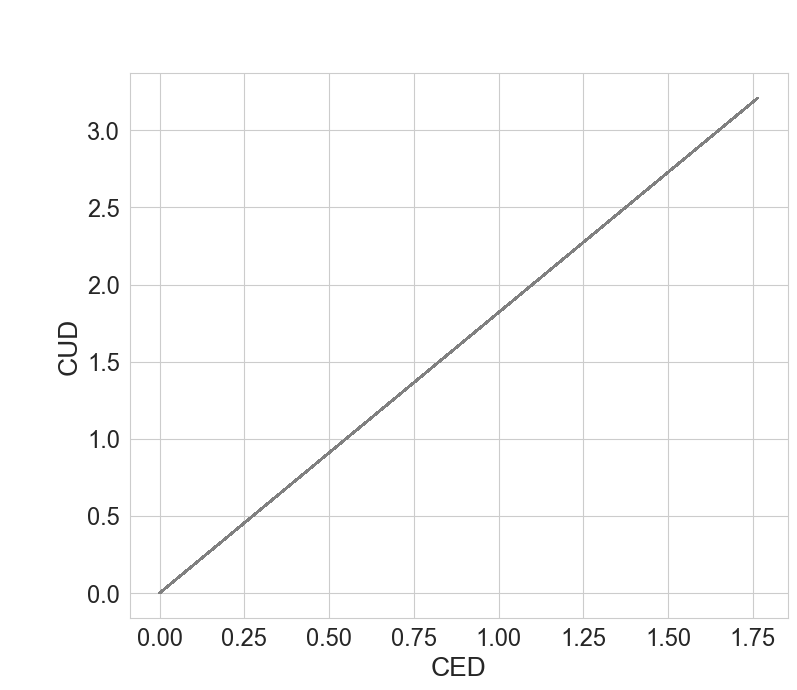

In [102]:
# plot showing ratios of marginal effects
# new zealand (NZL) is pretty much zero 
focus_countries         = ['FRA', 'NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['France', 'New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# Create a custom colormap
colors = ['indigo',
          'm', 
          'orchid',
          'darkseagreen',
          'forestgreen',
          'darkslategrey'
          ] 
custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
focus_colours = custom_cmap(np.linspace(0,1,7))


focus_colours = plt.get_cmap('RdYlBu_r')(np.linspace(0,1,11))[[0,4,6,7,8,9,10], :]

# colors = ['mediumvioletred',
#            'red',
#           'gold', 
#           'blue',
#           'mediumblue'
#           ] 

# custom_cmap = LinearSegmentedColormap.from_list('OrangeYellowGreen', colors[::-1], N=256)
# focus_colours = custom_cmap(np.linspace(0,1,11))[[0,5,6,7,8,9,10], :]




focus_linestyles        = [ (0,(1, 2)),'solid', (0, (3, 1, 1, 1, 1, 1)), (0, (5,1)), (0,(3, 1, 1, 1)), (0, (1,1)), (0, (5,5))] 
# focus_linestyles        = ['solid', 'solid', 'solid', 'solid', 'solid', 'solid'] 
country_params = country_model.params
global_params  = global_model.params


labelsize_large = 19
labelsize_medium = 17
labelsize_small  = 17

n_steps  = 100
x_exc   = np.linspace(0, 150, n_steps)

with sns.axes_style('whitegrid'):
    # x_Ts    = np.arange(10,30,0.025)
    x_Ts    = np.logspace(1,1.47719,500)
    n_lines = len(x_Ts)
    y_synth = np.array([compute_marginal_undershoot_effects_country(x_exc, x_T) for x_T in x_Ts])
    
    X_exc   = np.array([x_exc for i in range(n_lines)])
    
    fig, ax = plt.subplots(figsize = (8,7))
    # lc      = multiline(X_exc/85,  -(1-np.exp(y_synth))*100, x_Ts, cmap=sel_colormap, lw=2, alpha = .15)
    
    # cmap = plt.cm.get_cmap(sel_colormap)
    # cmap_reversed = mcolors.LinearSegmentedColormap.from_list(
    # sel_colormap, cmap(np.linspace(1, 0, cmap.N)))
    
    # lc2  = multiline(-X_exc/85-100,  -(1-np.exp(y_synth))*100, x_Ts[::-1], cmap=cmap_reversed, lw=2, alpha = .5)
    # axcb = fig.colorbar(lc2, cmap = cmap_reversed, fraction=0.04, pad=0.02)
    # # axcb.ax.tick_params(axis='both', which='major', labelsize = labelsize_small)

    # # axcb = fig.colorbar(lc)
    # # ticks = [10,12.5,15,17.5,20,22.5,25,27.5,30]
    # ticks = [10, 15, 20, 25, 30]
    # axcb.set_ticks(ticks)
    # axcb.set_ticklabels(ticks[::-1], fontsize = labelsize_small)
    
    # plot all countries 
    baselines = []
    lines     = []
    sub_df = regression_df.loc[regression_df.scen_run == 'CurPol_1', ['iso', 'tas_baseline']]
    for iso in sub_df.iso:
        coeff_ced = country_model.params[0] + country_model.params[1]*sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0]
        coeff_cud = country_model.params[2] + country_model.params[3]*sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0]
        baselines.append(sub_df.loc[sub_df.iso == iso, 'tas_baseline'].values[0])
        u_exc     = -coeff_ced*x_exc/coeff_cud 
        lines.append(u_exc)
        plt.plot(x_exc/85, u_exc/85, color = 'grey', alpha = 0.1)
        
    # ax.scatter(baselines, ratios, marker = 'x', color = 'grey', alpha = 0.3)
        
    # y_synth = compute_marginal_undershoot_effects_glboal(x_exc)
    # ax.plot(x_exc/85, y_synth, label = f'Global', color = 'black', linewidth = 3)
    
    # for i_country in range(len(focus_countries)): 
    #     country_iso     = focus_countries[i_country]
    #     country_name    = focus_countries_names[i_country]
    #     country_temp    = focus_temperatures[i_country]
    #     country_colour  = focus_colours[i_country]
    #     coeff_ced = country_model.params[0] + country_model.params[1]*country_temp
    #     coeff_cud = country_model.params[2] + country_model.params[3]*country_temp
    #     ax.scatter(country_temp, coeff_ced-coeff_cud, label = country_name, marker = 'X', s = 75, color = focus_colours[i_country])
        
    # axcb.set_label('Baseline Temperature [°C]', fontsize = labelsize_large)
    ax.legend(loc  = 'center left', ncols = 4, frameon = False, bbox_to_anchor=(-0.2, 1.1), fontsize = labelsize_medium)
    ax.set_xlabel('CED', fontsize = labelsize_large)
    ax.set_ylabel('CUD', fontsize = labelsize_large)
    ax.tick_params(axis='both', which='major', labelsize = labelsize_small)
    # plt.ylim(-2,2)
    # plt.xlim(-0.05, 1.8)
    plt.tight_layout()
    # plt.savefig(cset.path_GRAPHICS / "v1" / "marginal_effects_country.png" , dpi = 300)
    plt.savefig(cset.path_PROJECT / "Graphics"  / "v1" / "marginal_effects_country.png" , dpi = 300)
     
    plt.show()

### Temperature vs. Impact Reversibility

In [26]:
# load gmt data: 
gmt       = np.zeros((cset.n_scenarios*100, cset.n_years))
columns    = []
fair_ids_100  = pd.read_csv(cset.path_FAIR / 'ids_reconstructed.csv', sep = ',', index_col = 0).drop(columns = ['Ref']).rename(columns={'Ref_1p5': 'Ref'})
for i_scen in range(cset.n_scenarios): 
    scenario = cset.scenarios[i_scen]
    all_fair_runs = pd.read_csv(cset.path_FAIR / f'scen_{scenario}.csv', index_col = 0).iloc[:, fair_ids_100.loc[:, scenario].values]
    all_fair_runs.columns = np.arange(100)
    mesmer_ids = xr.load_dataset(cset.path_MESMER_fldmean / f'{scenario}_fldmean.nc')['fair_esm_variability_realisation'].values
    fair_ids_mesmer = [int(f.split('_')[0]) for f in mesmer_ids]
    gmt[i_scen*100:(i_scen+1)*100,:] = all_fair_runs.loc[slice(2015,2100), fair_ids_mesmer].T
    columns.append([scenario + f'_{int(i_run+1)}' for i_run in range(100)])
columns = np.array(columns).flatten()

i_sel_scenarios = [5, 2]
sel_scenarios   = [cset.scenarios[i_sel] for i_sel in i_sel_scenarios]

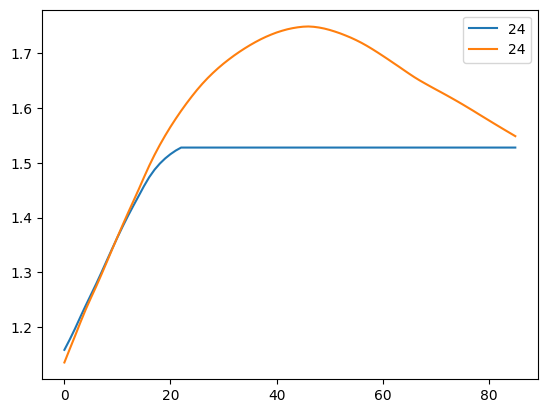

In [27]:
plt.figure()
# for i in np.argsort(np.abs(gmt[500:600, 0] - 1.15))[:5]:
#     plt.plot(gmt[500+i, :], label = i)
plt.plot(gmt[500+8, :], label = i)
plt.plot(gmt[200+89, :], label = i)
# for i in np.argsort(np.abs(gmt[200:300, 0] - 1.15))[:10]:
#     plt.plot(gmt[200+i, :], label = i)
plt.legend()
plt.show()

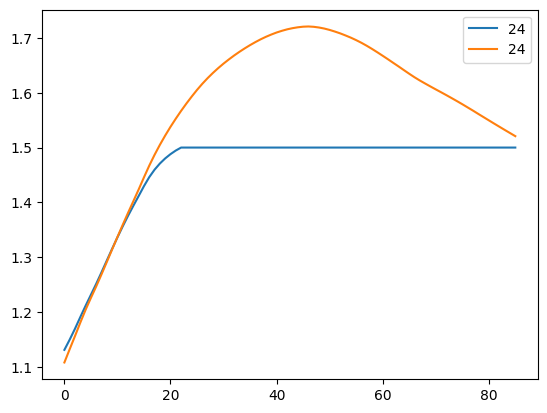

In [28]:
plt.figure()
# for i in np.argsort(np.abs(gmt[500:600, 0] - 1.15))[:5]:
#     plt.plot(gmt[500+i, :], label = i)
plt.plot(gmt[500+8, :]-0.0278, label = i)
plt.plot(gmt[200+89, :]-0.0278, label = i)
# for i in np.argsort(np.abs(gmt[200:300, 0] - 1.15))[:10]:
#     plt.plot(gmt[200+i, :], label = i)
plt.legend()
plt.show()

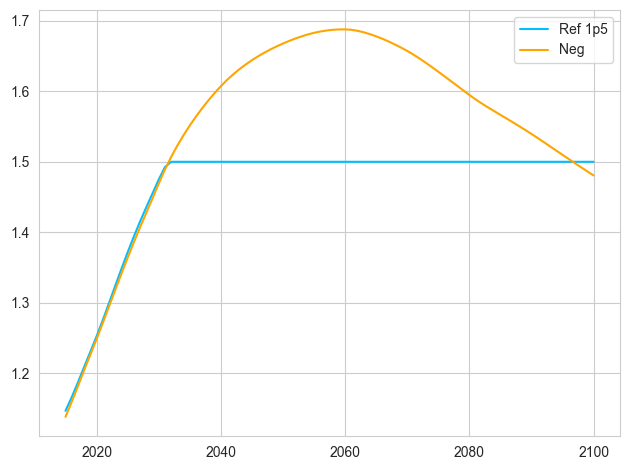

In [29]:
# trjajectories that end close to 1.5 and start between 1.1 and 1
gmt_ref = np.mean(gmt[500:600, :], axis = 0)
gmt_neg = np.mean(gmt[200:300, :], axis = 0)
gmt_ref[17:] = 1.5
# gmt_ref = gmt[500+8, :]-0.0278
# gmt_neg = gmt[200+89, :]-0.0278

with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), gmt_ref, color = '#00BFFF', label = 'Ref 1p5') 
    plt.plot(np.linspace(2015, 2100, 86), gmt_neg, color = '#FFA500', label = 'Neg')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [32]:
country_params = country_model.params
global_params  = global_model.params

def compute_full_effects_country(glmt, tas_baseline, glmt_eoc): 
    glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()/86
    print(glmt_exc)
    glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()/86
    print(glmt_uxc)
    # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+glmt_eoc**2*country_params[8]
    impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[4]+glmt_eoc*tas_baseline*country_params[5]
    # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+tas_baseline*country_params[4]+tas_baseline**2*country_params[5]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]
    return(impact)


0.08793396511627903
0.03684256976744191
0.0
0.03515138372093019


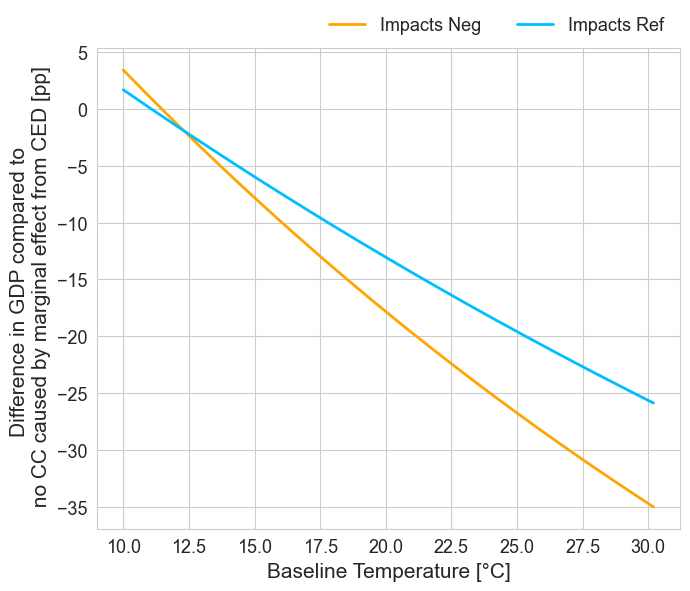

In [33]:
# x_Ts        = np.arange(5,30.05,0.05)

x_eocs = np.logspace(-10, 0.31, 500)
# x_Ts   = np.logspace(0.701, 1.48, 500)
x_Ts   = np.logspace(1, 1.48, 500)
impact_matrix_neg = -(1-np.exp(compute_full_effects_country(gmt_neg, x_Ts, gmt_neg[:].max())))*100
impact_matrix_ref = -(1-np.exp(compute_full_effects_country(gmt_ref, x_Ts, gmt_ref[:].max())))*100

with sns.axes_style('whitegrid'):
    plt.figure(figsize = (7,6))
    plt.plot(x_Ts, impact_matrix_neg, linewidth = 2, color = '#FFA500', label = 'Impacts Neg')
    plt.plot(x_Ts, impact_matrix_ref, linewidth = 2, color = '#00BFFF', label = 'Impacts Ref')
    
    # plt.axvline(12.8, color = 'black', linestyle = '--')
    

    plt.tick_params(labelsize = 13)
    plt.xlabel('Baseline Temperature [°C]', fontsize = 15)
    plt.ylabel('Difference in GDP compared to \n no CC caused by marginal effect from CED [pp]', fontsize = 15)
    plt.legend(ncols = 4, loc  = 'upper right', frameon = False, bbox_to_anchor=(1, 1.1), fontsize = 13)
    plt.tight_layout()
    plt.show()



In [46]:
np.logspace(-0.5, 0.31, 500)

array([0.31622777, 0.31741193, 0.31860053, 0.31979358, 0.3209911 ,
       0.3221931 , 0.3233996 , 0.32461062, 0.32582618, 0.32704628,
       0.32827096, 0.32950022, 0.33073409, 0.33197257, 0.3332157 ,
       0.33446347, 0.33571593, 0.33697307, 0.33823492, 0.33950149,
       0.34077281, 0.34204888, 0.34332974, 0.34461539, 0.34590586,
       0.34720116, 0.34850131, 0.34980632, 0.35111623, 0.35243104,
       0.35375077, 0.35507545, 0.35640508, 0.3577397 , 0.35907931,
       0.36042394, 0.3617736 , 0.36312832, 0.36448811, 0.36585299,
       0.36722299, 0.36859811, 0.36997839, 0.37136383, 0.37275446,
       0.3741503 , 0.37555136, 0.37695767, 0.37836925, 0.37978611,
       0.38120828, 0.38263577, 0.38406861, 0.38550682, 0.38695041,
       0.38839941, 0.38985383, 0.3913137 , 0.39277903, 0.39424986,
       0.39572619, 0.39720805, 0.39869545, 0.40018843, 0.401687  ,
       0.40319118, 0.40470099, 0.40621646, 0.4077376 , 0.40926444,
       0.41079699, 0.41233529, 0.41387934, 0.41542918, 0.41698

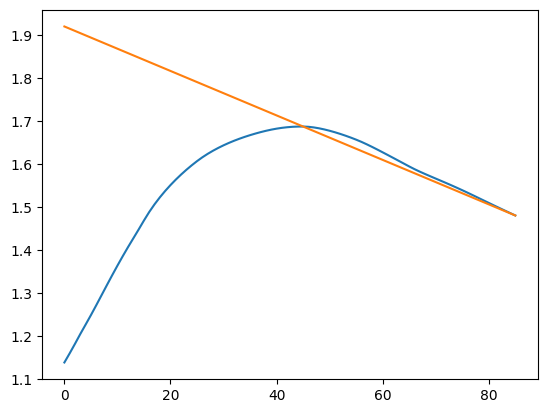

0.050010461189026204
0.27647910998733943
0.050015797831654434
0.27620217485913695
0.0500230538126506
0.27592610205835333
0.05003033696480857
0.2756489954596289
0.050037647389870814
0.27537085119176147
0.05004498518996809
0.27509166536902435
0.050052350467608586
0.27481143409115966
0.05005974332568863
0.2745301534432855
0.05006716386748414
0.2742478194958872
0.05007461219666427
0.2739644283047041
0.050082088417282566
0.27367997591072646
0.05008959263378071
0.2733944583401218
0.05009712495099746
0.27310787160415184
0.050104685474157265
0.2728202116991715
0.050112274308881134
0.27253147460653865
0.05011989156119065
0.27224165629252967
0.05012753733749618
0.27195075270835967
0.050135211744609165
0.2716587597900715
0.050142914889744386
0.2713656734584704
0.05015064688051635
0.27107148961909716
0.05015840782494192
0.2707762041621617
0.05016619783144217
0.270479812962486
0.050174017008843316
0.2701823118794513
0.05018186546638106
0.2698836967569183
0.05018974331370157
0.26958396342318447
0.05

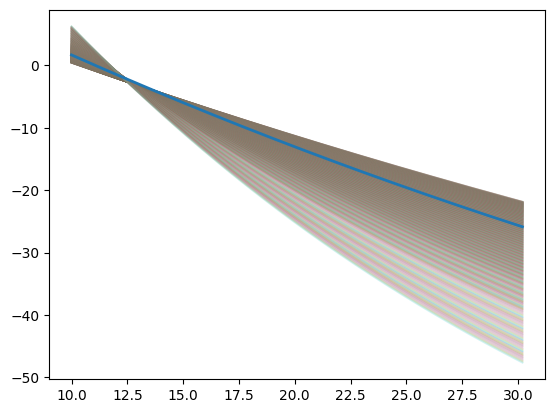

In [47]:
# use a log scale to get a better resolution for the lower temperatures
# assume tas_soc and country_fiexed_effects are the smae for all countries
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [gmt_neg[45], gmt_neg[-1]], 1)
y_lin_og  = p[0]*x + p[1]
plt.figure()
plt.plot(gmt_neg)
plt.plot(y_lin_og)
plt.show()

# x_Ts = np.arange(5,30.05,0.05)
x_eocs = np.logspace(-0.5, 0.31, 500)

impact_matrix_neg_adj    = []
# for x_eoc in np.arange(10**,-1,-0.01):
for x_eoc in x_eocs:
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]

    impact_matrix_neg_adj_tmp = -(1-np.exp(compute_full_effects_country(gmt_neg_adj, x_Ts, gmt_neg_adj.max())))*100
    impact_matrix_neg_adj.append(impact_matrix_neg_adj_tmp)

impact_matrix_neg_adj = np.array(impact_matrix_neg_adj)


plt.figure()
plt.plot(x_Ts, impact_matrix_neg_adj.T, alpha = .2)
plt.plot(x_Ts, impact_matrix_ref, color = 'C0', linewidth = 2, label = 'Impacts Ref')
plt.show()

0.050010461189026204
0.27647910998733943
0.050015797831654434
0.27620217485913695
0.0500230538126506
0.27592610205835333
0.05003033696480857
0.2756489954596289
0.050037647389870814
0.27537085119176147
0.05004498518996809
0.27509166536902435
0.050052350467608586
0.27481143409115966
0.05005974332568863
0.2745301534432855
0.05006716386748414
0.2742478194958872
0.05007461219666427
0.2739644283047041
0.050082088417282566
0.27367997591072646
0.05008959263378071
0.2733944583401218
0.05009712495099746
0.27310787160415184
0.050104685474157265
0.2728202116991715
0.050112274308881134
0.27253147460653865
0.05011989156119065
0.27224165629252967
0.05012753733749618
0.27195075270835967
0.050135211744609165
0.2716587597900715
0.050142914889744386
0.2713656734584704
0.05015064688051635
0.27107148961909716
0.05015840782494192
0.2707762041621617
0.05016619783144217
0.270479812962486
0.050174017008843316
0.2701823118794513
0.05018186546638106
0.2698836967569183
0.05018974331370157
0.26958396342318447
0.05

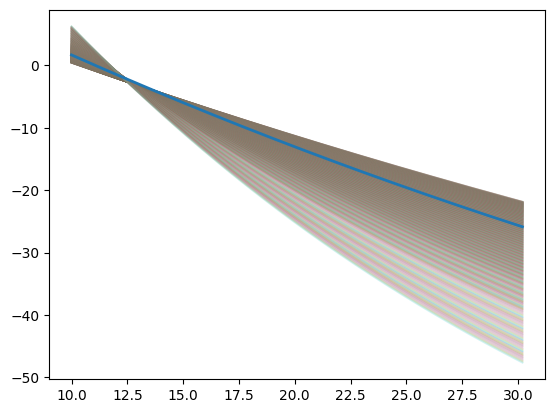

In [48]:
# construct linear function that does through 2060 - max value glmt and 2100 - some eoc value 
# test for different eoc values and construct mean trajectory 

impact_matrix_neg_adj    = []
# for x_eoc in np.arange(2,-1,-0.01):
for x_eoc in x_eocs:
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]
    
    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]

    impact_matrix_neg_adj_tmp = -(1-np.exp(compute_full_effects_country(gmt_neg_adj, x_Ts,gmt_neg_adj.max())))*100
    impact_matrix_neg_adj.append(impact_matrix_neg_adj_tmp)

impact_matrix_neg_adj = np.array(impact_matrix_neg_adj)


plt.figure()
plt.plot(x_Ts, impact_matrix_neg_adj.T, alpha = .2)
plt.plot(x_Ts, impact_matrix_ref, color = 'C0', linewidth = 2, label = 'Impacts Ref')
plt.show()

In [49]:
idx_min = np.abs(impact_matrix_neg_adj-impact_matrix_ref).argmin(axis = 0)

In [50]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc  = x_eocs[idx]
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [gmt_neg[45], x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = gmt_neg.copy()
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

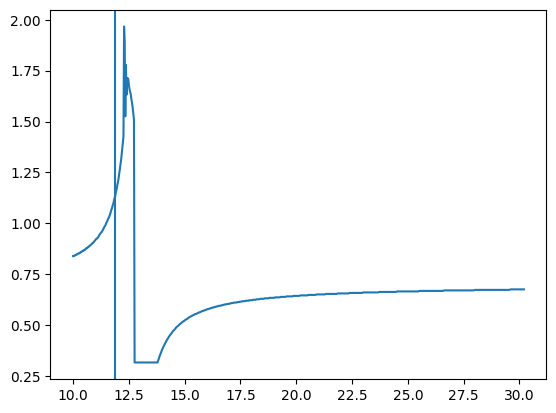

In [51]:
plt.figure()
plt.plot(x_Ts, x_eocs[idx_min])
plt.axvline(11.9)
plt.show()

In [52]:
idx_country = [np.abs(x_Ts-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]

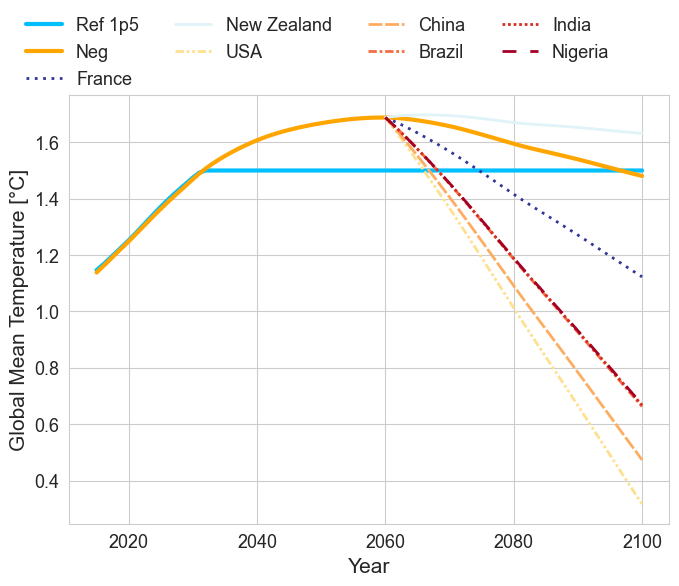

In [53]:
idx_country = [np.abs(x_Ts-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]
with sns.axes_style('whitegrid'):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize = (7,6))
        plt.plot(np.linspace(2015,2100,86), gmt_ref, color = '#00BFFF', linewidth = 3, label = 'Ref 1p5')
        plt.plot(np.linspace(2015,2100,86), gmt_neg, color = '#FFA500', linewidth = 3, label = 'Neg')
        # lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(501-150)]),  gmt_trajectories_equal[150:, 45:], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
        for i_country in range(len(focus_countries)):
            plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = focus_linestyles[i_country])
        plt.tick_params(labelsize = 13)
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
        plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
        plt.tight_layout()
        plt.show()

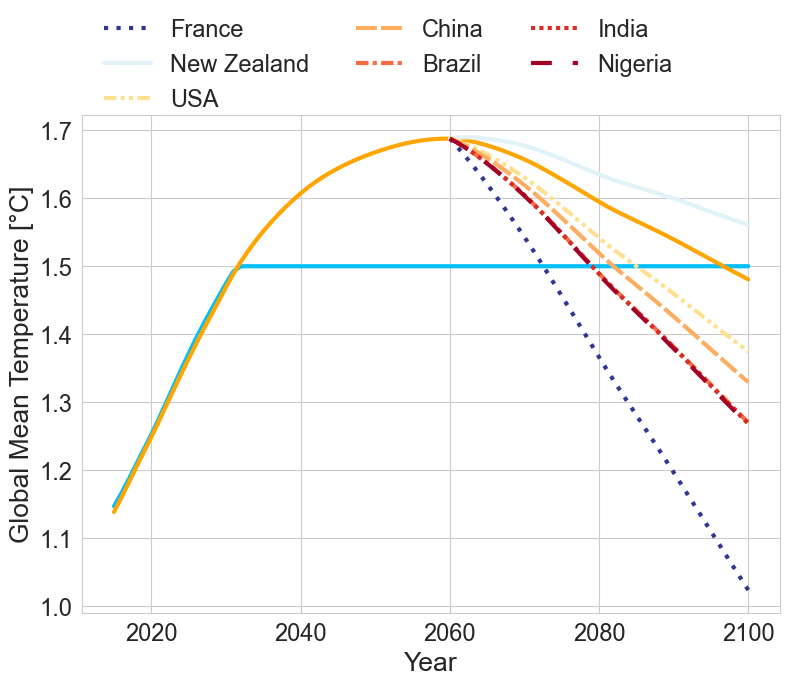

In [262]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize = (8,7))
    plt.plot(np.linspace(2015, 2100, 86), gmt_ref, color = '#00BFFF', linewidth = 3)
    plt.plot(np.linspace(2015, 2100, 86), gmt_neg, color = '#FFA500', linewidth = 3)
    
    # lc  = multiline(np.array([np.linspace(2015,2100,86) for i in range(501-150)]),  gmt_trajectories_equal[150:, :], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    for i_country in range(len(focus_countries)):
        plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 3, linestyle = focus_linestyles[i_country])

    plt.tick_params(labelsize = labelsize_small)
    plt.xlabel('Year', fontsize = labelsize_large)
    plt.ylabel('Global Mean Temperature [°C]', fontsize =  labelsize_large)
    plt.legend(ncols = 3, loc  = 'center left', frameon = False, bbox_to_anchor=(0, 1.1), fontsize =  labelsize_medium)
    plt.tight_layout()
    plt.show()

In [163]:
isos      = regression_df[regression_df.scen_run == 'CurPol_1'].iso.values
baselines = regression_df[regression_df.scen_run == 'CurPol_1'].tas_baseline.values
world.loc[isos, 'tas_baseline'] = baselines
world.loc[isos, 'neg_effect']   =  -(1-np.exp(compute_full_effects_country(gmt_neg, world.loc[isos, 'tas_baseline'].values, gmt_neg[-1].mean())))*100
world.loc[isos, 'ref_effect']   =  -(1-np.exp(compute_full_effects_country(gmt_ref, world.loc[isos, 'tas_baseline'].values, gmt_ref[-1].mean())))*100
world.loc[isos, 'diff_effect']  = world.loc[isos, 'neg_effect'] - world.loc[isos, 'ref_effect']

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


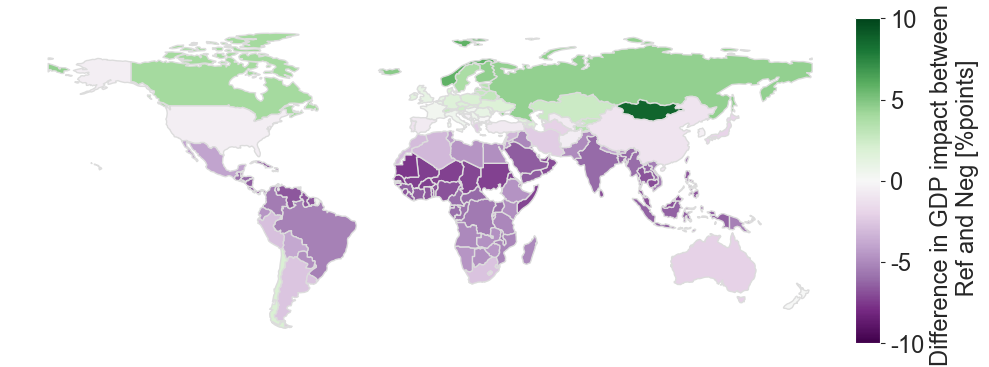

/Users/schoens/opt/anaconda3/envs/py39_mesmer-m/lib/python3.9/site-packages/geopandas/plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


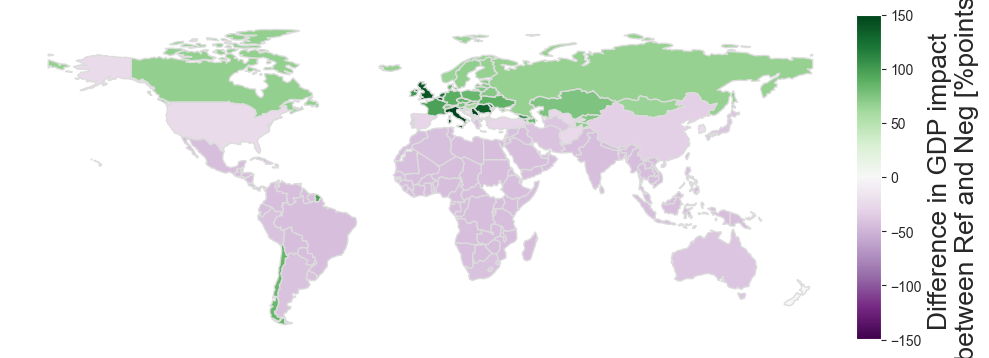

In [191]:
import geopandas as gpd 
from matplotlib import colormaps as cm
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.loc[world.name == 'France', 'iso_a3'] = 'FRA'
world.loc[world.name == 'Norway', 'iso_a3'] = 'NOR'
world.index = world.iso_a3

# for each country: get baeline temperature:
isos      = regression_df[regression_df.scen_run == 'CurPol_1'].iso.values
baselines = regression_df[regression_df.scen_run == 'CurPol_1'].tas_baseline.values
world.loc[isos, 'tas_baseline']     = baselines
world.loc[isos, 'neg_effect']       =  -(1-np.exp(compute_full_effects_country(gmt_neg, world.loc[isos, 'tas_baseline'].values, gmt_neg[-1].mean())))*100
world.loc[isos, 'ref_effect']       =  -(1-np.exp(compute_full_effects_country(gmt_ref, world.loc[isos, 'tas_baseline'].values, gmt_ref[-1].mean())))*100
world.loc[isos, 'diff_effect']      = world.loc[isos, 'neg_effect'] - world.loc[isos, 'ref_effect']
world.loc[isos, 'diff_effect_rel']  = (world.loc[isos, 'neg_effect']-world.loc[isos, 'ref_effect'])/np.abs(world.loc[isos, 'ref_effect'])*100
# plot impacts on a world map
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely import box
with sns.axes_style('darkgrid'):
    for scenario in ['CurPol']:
        fig, ax = plt.subplots(ncols=1,nrows=1, figsize = (10,6))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['PRGn'].copy()
        # cmap2.set_under((1.0, 0.9607843137254902, 0.9215686274509803, 1.0), 0.5)
        # world.plot(column='no_growth_count', ax=ax, color = 'lightgrey')
        world.plot(column=f'diff_effect', ax=ax, legend=True, cmap = cmap2, cax = cax, vmin = -10, vmax = 10, edgecolor = 'gainsboro')
        # cbar.set_label('Percentage of runs in category')
        # cax.set_yticks([1,2,3,4,5])
        # cax.set_yticklabels(scenarios)
        ax.set_axis_off()
        cax.set_ylabel('Difference in GDP impact between \n Ref and Neg [%points]', fontsize = labelsize_medium)
        cax.set_yticks([-10, -5, 0, 5, 10])
        cax.set_yticklabels([-10, -5, 0, 5, 10], fontsize = labelsize_small)
        # xMin, yMin, xMax, yMax = world.total_bounds
        # boxx  = gpd.GeoDataFrame(geometry=[box(xMin, yMin, xMax, yMax)])
        # boxx.plot(ax=ax, color="lightgrey", zorder=0)
        
        plt.tight_layout()
        plt.show()
        
with sns.axes_style('darkgrid'):
    for scenario in ['CurPol']:
        fig, ax = plt.subplots(ncols=1,nrows=1, figsize = (10,8))
        divider = make_axes_locatable(ax)
        cax     = divider.append_axes('right', size='3%', pad=0.04)
        cmap2 = cm['PRGn'].copy()
        # cmap2.set_under((1.0, 0.9607843137254902, 0.9215686274509803, 1.0), 0.5)
        # world.plot(column='no_growth_count', ax=ax, color = 'lightgrey')
        world.plot(column=f'diff_effect_rel', ax=ax, legend=True, cmap = cmap2, vmin = -150, vmax = 150, cax = cax, edgecolor = 'gainsboro')
        # cbar.set_label('Percentage of runs in category')
        # cax.set_yticks([1,2,3,4,5])
        # cax.set_yticklabels(scenarios)
        ax.set_axis_off()
        cax.set_ylabel('Difference in GDP impact \n between Ref and Neg [%points]', fontsize = labelsize_large)
        # cax.set_yticks([-10, -5, 0, 5, 10])
        # cax.set_yticklabels([-10, -5, 0, 5, 10], fontsize = labelsize_small)
        # xMin, yMin, xMax, yMax = world.total_bounds
        # boxx  = gpd.GeoDataFrame(geometry=[box(xMin, yMin, xMax, yMax)])
        # boxx.plot(ax=ax, color="lightgrey", zorder=0)
        
        plt.tight_layout()
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


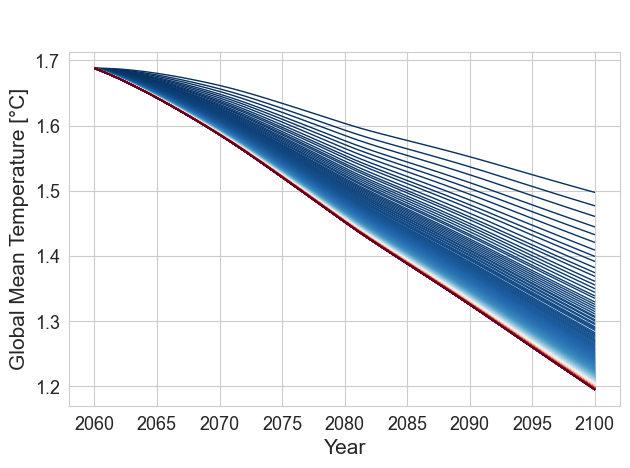

In [146]:
with sns.axes_style('whitegrid'):
    plt.figure()
    lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(500-104)]),  gmt_trajectories_equal[104:, 45:], x_Ts[104:], cmap='RdBu_r', lw=1, alpha =1)
    # plt.plot(np.linspace(2015, 2100, 86), gmt_ref, color = '#00BFFF', label = 'Ref 1p5', linewidth = 2)
    # plt.plot(np.linspace(2015, 2100, 86), gmt_neg, color = '#FFA500', label = 'Neg', linewidth = 2)
    # for i_country in range(len(focus_countries)):
    #     plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = focus_linestyles[i_country])

    plt.tick_params(labelsize = 13)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
    plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
    plt.tight_layout()
    plt.show()

In [35]:
regression_df

gmt_exc  gmt_exc tas_baseline  gmt_uxc  gmt_uxc tas_baseline  \
0       58.6091            799.059937   1.3213             18.014231   
1       23.2068            316.394965   8.8533            120.703395   
2       61.7119            841.362637   1.2459             16.986249   
3       23.2068            316.394965   8.8533            120.703395   
4       30.3003            413.105743   7.0426             96.016822   
...         ...                   ...      ...                   ...   
156995  34.7284            757.032831   3.7032             80.724824   
156996  31.0815            677.535272   2.9677             64.691904   
156997  31.0815            677.535272   2.9677             64.691904   
156998  72.3633           1577.423488   1.8696             40.754788   
156999  55.1604           1202.423197   1.1651             25.397627   

          tas_soc   tas_soc^2  gmt_eoc  gmt_eoc tas_baseline  log_diff_SSP2  \
0       14.288971  204.174686   3.1931             43.533825      -0.126496   
1       14.951891  223.559030   2.4112             32.873621      -0.014225   
2       14.445878  208.683381   3.3060             45.073071      -0.106559   
3       13.568798  184.112267   2.4112             32.873621      -0.122939   
4       14.115947  199.259967   2.6126             35.619451      -0.108812   
...           ...         ...      ...                   ...            ...   
156995  21.591091  466.175227   1.8069             39.388012      -1.099045   
156996  21.546010  464.230555   1.7505             38.158567      -0.924679   
156997  22.613370  511.364517   1.7505             38.158567       0.002094   
156998  21.987921  483.468685   2.5757             56.146827      -0.839979   
156999  21.884384  478.926256   2.0966             45.703085      -0.668639   

        iso        scen_run  tas_baseline  
0       AFG        CurPol_1     13.633718  
1       AFG       CurPol_10     13.633718  
2       AFG      CurPol_100     13.633718  
3       AFG       CurPol_11     13.633718  
4       AFG       CurPol_12     13.633718  
...     ...             ...           ...  
156995  ZWE  ssp534-over_95     21.798667  
156996  ZWE  ssp534-over_96     21.798667  
156997  ZWE  ssp534-over_97     21.798667  
156998  ZWE  ssp534-over_98     21.798667  
156999  ZWE  ssp534-over_99     21.798667  

[157000 rows x 12 columns]

In [38]:
iso = 'FRA'
print(iso)
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run == 'Ref_8')].loc[:, 'log_diff_SSP2'].values))
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run == 'Neg_89')].loc[:, 'log_diff_SSP2'].values))
for iso in focus_countries: 
    print(iso)
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run == 'Ref_8')].loc[:, 'log_diff_SSP2'].values))
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run == 'Neg_89')].loc[:, 'log_diff_SSP2'].values))

FRA
[1.02372958]
[0.96589007]
NZL
[0.99752964]
[0.99815256]
USA
[0.97961414]
[0.98339371]
CHN
[0.99078969]
[1.07500826]
BRA
[0.96293457]
[1.69790966]
IND
[0.61022627]
[5.10844197]
NGA
[0.81963772]
[1.63128282]


In [145]:
iso = 'FRA'
print(iso)
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).median())
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).median())
for iso in focus_countries: 
    print(iso)
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).median())
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).median())

FRA
1.015917411022973
1.0016869106932322
NZL
0.9983041892474647
0.9999659245669039
USA
0.9839558759108177
0.9798688756012782
CHN
1.0177951629873505
0.9969161842764993
BRA
0.761572995680085
0.6930131241938862
IND
0.6505108742316661
0.6520099686023618
NGA
0.6658071886348456
0.7391279663794479


In [53]:
iso = 'FRA'
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).mean())
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).mean())

1.021397469041273
1.020468197809541


In [54]:
iso = 'BRA'
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).mean())
print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).mean())

0.8120075314271875
0.7179862466179122


In [55]:
country_params = country_model.params
global_params  = global_model.params

print(np.unique(regression_df.iso)[19])

iso_id       = 19
tas_baseline = 23.86

def realistic_impact(glmt, tas_baseline, glmt_eoc): 
    glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()
    glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()
    # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+glmt_eoc**2*country_params[8]
    impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+tas_baseline*country_model.params[4]+tas_baseline**2*country_model.params[5]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+country_params[iso_id+8]
    return(impact)

print(np.exp(realistic_impact(gmt_ref, tas_baseline, gmt_ref[-1].mean())))
print(np.exp(realistic_impact(gmt_neg, tas_baseline, gmt_neg[-1].mean())))

BRA
0.7416168186527458
0.6972028815156265


In [91]:
country_params = country_model.params
global_params  = global_model.params

gmt_ref = np.mean(gmt[500:600, :], axis = 0)
gmt_neg = np.mean(gmt[200:300, :], axis = 0)

gmt_ref[17:] = 1.5

for iso in focus_countries: 
    print(iso)

    iso_id       = np.argwhere(np.unique(regression_df.iso) == iso).flatten()[0]
    tas_baseline = regression_df[regression_df.iso == np.unique(regression_df.iso)[iso_id]]['tas_baseline'].mean()

    def realistic_impact(glmt, tas_baseline, glmt_eoc): 
        glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()
        glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()
        # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+glmt_eoc**2*country_params[8]
        impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+tas_baseline*country_model.params[4]+tas_baseline**2*country_model.params[5]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+country_params[iso_id+8]
        return(impact)

    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).mean(), np.exp(realistic_impact(gmt_ref, tas_baseline, gmt_ref[-1].mean())))
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).mean(), np.exp(realistic_impact(gmt_neg, tas_baseline, gmt_neg[-1].mean())))

NZL
1.0030987982200466 0.9969242341844229
1.0036433369326871 0.9970044738479901
USA
0.9847126283058535 0.9681085684189676
0.9777617864197523 0.9631023443853941
CHN
1.0131292207794484 1.0039758259976779
0.9959466351312186 0.9933410647873175
BRA
0.8120075314271875 0.7423903592176428
0.7179862466179122 0.6969312932536393
IND
0.7416357329548358 0.7330989274741091
0.8084290530460365 0.6811254402976096
NGA
0.7139194564013158 0.6961446175691938
0.7739035962231653 0.6397467316062634


In [146]:
country_params = country_model.params
global_params  = global_model.params

for iso in ['MLI', 'SEN', 'GHA']: 
    print(iso)

    iso_id       = np.argwhere(np.unique(regression_df.iso) == iso).flatten()[0]
    tas_baseline = regression_df[regression_df.iso == np.unique(regression_df.iso)[iso_id]]['tas_baseline'].mean()

    def realistic_impact(glmt, tas_baseline, glmt_eoc): 
        glmt_exc = (glmt[glmt>thrshld]-thrshld).sum()
        glmt_uxc = -(glmt[glmt<thrshld]-thrshld).sum()
        # impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+glmt_eoc**2*country_params[8]
        impact   = glmt_exc*country_params[0]+glmt_exc*tas_baseline*country_params[1]+glmt_uxc*country_params[2]+glmt_uxc*tas_baseline*country_params[3]+tas_baseline*country_model.params[4]+tas_baseline**2*country_model.params[5]+glmt_eoc*country_params[6]+glmt_eoc*tas_baseline*country_params[7]+country_params[iso_id+8]
        return(impact)

    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).mean(), np.exp(realistic_impact(gmt_ref, tas_baseline, gmt_ref[-1].mean())))
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).mean(), np.exp(realistic_impact(gmt_neg, tas_baseline, gmt_neg[-1].mean())))

MLI
0.6835743837621542 0.5642892097861031
0.6943288168052082 0.49909950502514927
SEN
0.6360175554994701 0.5607083538700087
0.6201219386064362 0.49497459571497654
GHA
0.7377250440033951 0.750673526543586
0.7661651407482044 0.6725706022892467


In [68]:
# countries: China, India, USA, Brazil, Nigeria, New Zealand
for iso in focus_countries[-3:]: 
    print(iso)
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Ref'))].loc[:, 'log_diff_SSP2']).mean())
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('Neg'))].loc[:, 'log_diff_SSP2']).mean())
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('SP'))].loc[:, 'log_diff_SSP2']).mean())
    print(np.exp(regression_df[(regression_df.iso == iso) & (regression_df.scen_run.str.contains('ssp119'))].loc[:, 'log_diff_SSP2']).mean())

BRA
0.8120075314271875
0.7179862466179122
0.8543659192448803
0.8010096073540258
IND
0.7416357329548358
0.8084290530460365
0.8650712987668233
0.839842135202638
NGA
0.7139194564013158
0.7739035962231653
0.7861654687031964
0.8120444848365084


In [35]:
# take Ref1p5 and Neg as examples: 
scenarios = ['Ref1p5', 'Neg']
# scenarios = ['ssp119', 'SP', 'GS', 'ssp534-over', 'CurPol']

list_gmt_mean = []
for i_scen in range(len(scenarios)):
    scenario = scenarios[i_scen]
    gmt_mean = pd.read_csv(Path.joinpath(cset.path_FAIR, f'scen_{scenario}.csv'), index_col = 0).mean(axis = 1).loc[slice(2015,2100)].values
    list_gmt_mean.append(gmt_mean)


# translating EOC temperatures back:  
plt.figure()
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5')
plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [list_gmt_mean[1][45], list_gmt_mean[1][-1]], 1)
y_lin_og  = p[0]*x + p[1]
plt.figure()
plt.plot(list_gmt_mean[1])
plt.plot(y_lin_og)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/schoens/Documents/Projekte/Econ/Data/FaIR_v3/scen_Ref1p5.csv'

In [126]:
gmt_trajectories_equal = []

for i in range(len(x_Ts)): 
    idx    = idx_min[i]
    x_eoc = np.arange(2.5,-1,-0.01)[idx]-0.565
    
    x         = np.linspace(2015, 2100, 86)
    p         = np.polyfit([2060, 2100], [ 1.705, x_eoc], 1)
    y_lin     = p[0]*x + p[1]

    gmt_neg_adj      = list_gmt_mean[1]+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:]-y_lin_og[45:]
    
    gmt_trajectories_equal.append(gmt_neg_adj)
    
gmt_trajectories_equal = np.array(gmt_trajectories_equal)

In [127]:
focus_countries         = ['NZL', 'USA', 'CHN', 'BRA', 'IND', 'NGA']
focus_countries_names   = ['New Zealand', 'USA', 'China', 'Brazil', 'India', 'Nigeria']
focus_temperatures      = [regression_df[regression_df.iso == country].loc[:, 'tas_baseline'].mean() for country in focus_countries] 
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = ['dodgerblue', '#ffbf00', '#ff7f0e', 'crimson', 'orchid', '#7f3f98']
# focus_colours           = [sns.color_palette("tab10")[i] for i in [0,9,1,2,4,7]]
# focus_colours           = [(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 
#                            (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                            (1.0, 0.4980392156862745, 0.054901960784313725), 
#                            (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
#                            '#7f3f98',
#                            '#ffbf00'
#                            ]
# focus_colours = [(0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
#                  '#089099', 
#                  '#045275', 
#                  'maroon', 
#                  '#008080', 
#                  '#ffbf00' ]
'#045275'

focus_colours = ['dodgerblue',
                 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
                 'darkgoldenrod',
                 'maroon', 
                 '#008080', 
                 'gold' ]



In [128]:
idx_country = [np.abs(x_Ts-focus_temperatures[i_country]).argmin() for i_country in range(len(focus_countries))]

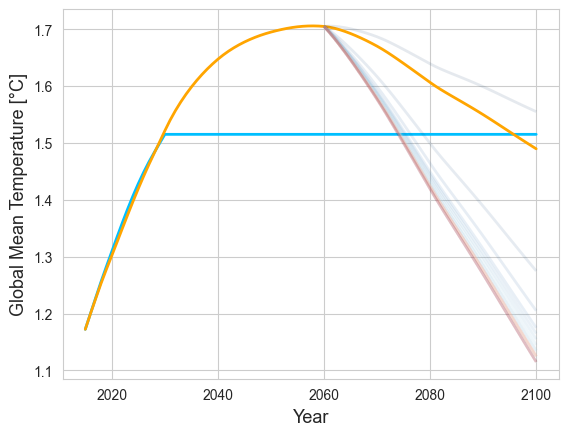

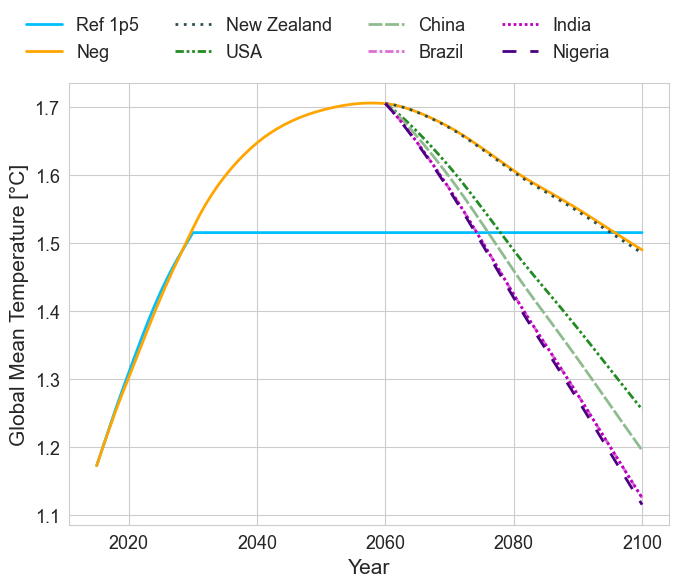

In [141]:
with sns.axes_style('whitegrid'):
    plt.figure()
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5', linewidth = 2)
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg', linewidth = 2)
    
    lc  = multiline(np.array([np.linspace(2015,2100,86)[45:] for i in range(20)]),  gmt_trajectories_equal[150:, 45:][::18], x_Ts[150:][::18], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    # for i_country in range(len(focus_countries)):
    #     plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = '-')

    plt.xlabel('Year', fontsize = 13)
    plt.ylabel('Global Mean Temperature [°C]', fontsize = 13)
    plt.show()

with sns.axes_style('whitegrid'):
    plt.figure(figsize = (7,6))
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[0], color = '#00BFFF', label = 'Ref 1p5', linewidth = 2)
    plt.plot(np.linspace(2015, 2100, 86), list_gmt_mean[1], color = '#FFA500', label = 'Neg', linewidth = 2)
    
    # lc  = multiline(np.array([np.linspace(2015,2100,86) for i in range(501-150)]),  gmt_trajectories_equal[150:, :], x_Ts[150:], cmap='RdBu_r', lw=2, alpha =.1)
    # plt.plot(gmt_trajectories_equal.T, color = 'C1', alpha = .1)
    # plt.plot(gmt_trajectories_equal.T[:, ::50])
    for i_country in range(len(focus_countries)):
        plt.plot(np.linspace(2015,2100,86)[45:], gmt_trajectories_equal[idx_country[i_country], 45:], color = focus_colours[i_country], label = focus_countries_names[i_country], linewidth = 2, linestyle = focus_linestyles[i_country])

    plt.tick_params(labelsize = 13)
    plt.xlabel('Year', fontsize = 15)
    plt.ylabel('Global Mean Temperature [°C]', fontsize = 15)
    plt.legend(ncols = 4, loc  = 'center left', frameon = False, bbox_to_anchor=(-0.1, 1.1), fontsize = 13)
    plt.tight_layout()
    plt.show()

In [ ]:
x_GEOC    = np.arange(2.5,-1,-0.01)[idx_min]-0.6
x         = np.linspace(2015, 2100, 86)
p         = np.polyfit([2060, 2100], [1.705, x_eoc], 1)
y_lin     = p[0]*x + p[1]

for i in range(100):
    gmt_neg_adj      = list_gmt_mean[1][45]+glmt_plus
    gmt_neg_adj[45:] += y_lin[45:] - y_lin_og[45:]


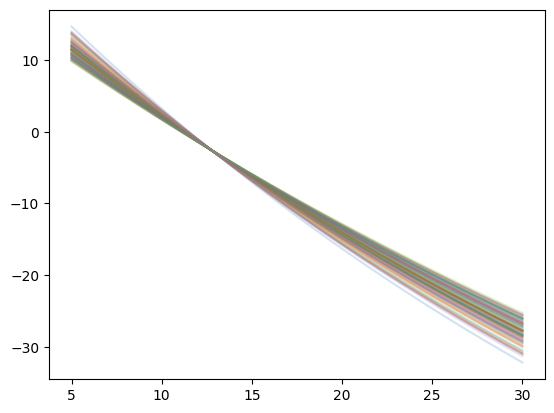

In [48]:
plt.figure()
plt.plot(x_Ts, impact_matrix_ref.T, alpha = .2)
plt.show()

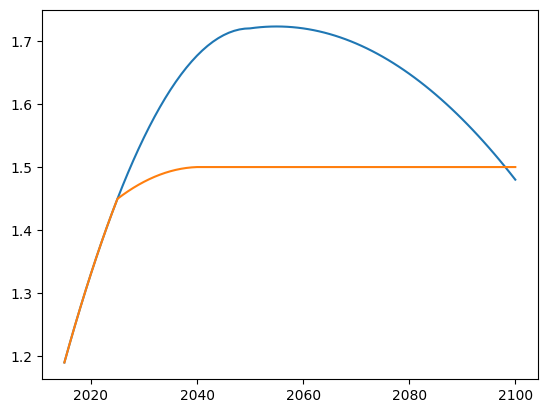

In [263]:
x_eoc = 1.5
x_os  = 1.72
x_soc = 1.2

x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)

# overshoot pathway: 2015 - 1.1, 2050 - 1.75, 2100 - 1.5
p1    = np.polyfit([2015, 2050, 2085], 
                    [x_soc-0.01, x_os, x_soc-0.01],
                    deg = 2)

p2    = np.polyfit([2010, 2050, 2100], 
                    [x_eoc-0.02, x_os ,x_eoc-0.02],
                    deg = 2)

gmt_3        = p1[0]*x**2+p1[1]*x+p1[2]
# gmt_3[36:40] = gmt_3[35]
gmt_3[36:]   = p2[0]*x[36:]**2+p2[1]*x[36:]+p2[2]

# ref pathway: 
p1    = np.polyfit([2025, 2030, 2040], 
                    [gmt_3[10], gmt_3[10]+0.027, x_eoc],
                    deg = 2)

gmt_2        = gmt_3.copy()
gmt_2[10:26] = p1[0]*x[10:26]**2+p1[1]*x[10:26]+p1[2]
gmt_2[26:]   = gmt_2[25]


plt.figure()
# plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.plot(x, gmt_2)
plt.show()

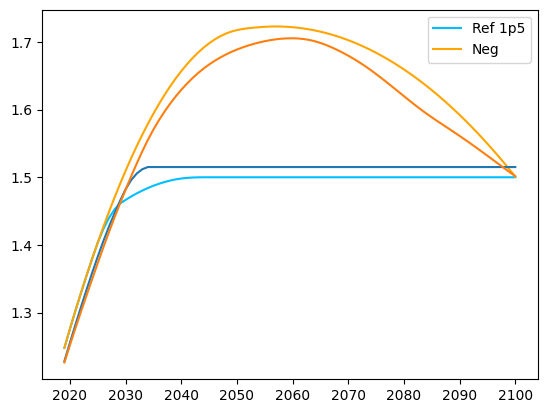

In [264]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=False, min_periods=5).mean().to_numpy()[:, 0]


gmt_2_smooth = rollavg_pandas(gmt_2,5)
gmt_3_smooth = rollavg_pandas(gmt_3,5)

plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.plot(x, gmt_ref_smooth)
plt.plot(x, gmt_neg_smooth)
plt.legend()
plt.show()

In [ ]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

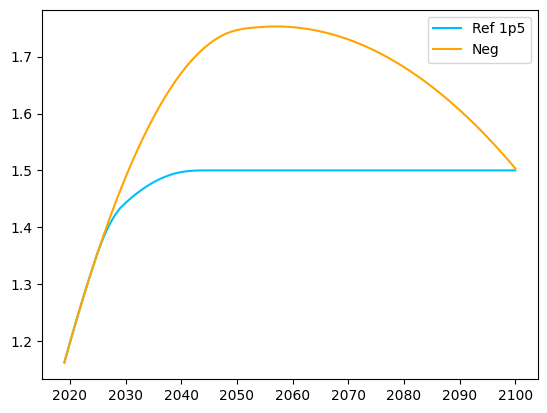

In [247]:
plt.figure()
plt.plot(x, gmt_2_smooth, color = '#00BFFF', label = 'Ref 1p5')
plt.plot(x, gmt_3_smooth, color = '#FFA500', label = 'Neg')
plt.legend()
plt.show()

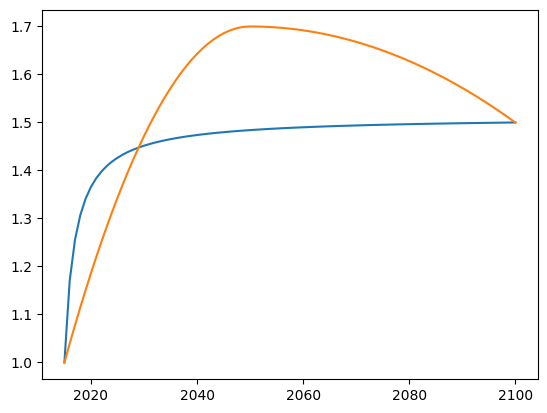

In [205]:
# constructing pathways 

# trajectory without peak and decline: 
x_eoc = 1.5
x_os  = 1.75
scale = 0.5

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*scale/(1+x_gen*scale), 
                    [1,x_eoc],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*scale/(scale*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,x_os,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [x_eoc,x_os,x_eoc],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

plt.figure()
plt.plot(x, gmt_2)
plt.plot(x, gmt_3)
plt.show()

In [177]:
import pandas as pd
def rollavg_pandas(a,n):
    'Pandas rolling average'
    return pd.DataFrame(a).rolling(n, center=True, min_periods=1).mean().to_numpy()[:, 0]

n_scenarios = 10
scenarios   = cset.scenarios
gmt_smooth  = np.zeros((n_scenarios, 86, 100))
for i_scen in range(len(scenarios)): 
    scenario = scenarios[i_scen]
    glmt_tmp = xr.load_dataset(Path.joinpath(cset.path_MESMER_fldmean, f"{scenario}_fldmean.nc"))['tas'].values
    glmt_ref = glmt_tmp[:, :50].mean(axis = 1)
    gmt_realisations_tmp     = (glmt_tmp[:, :].T - glmt_ref)
    gmt_realisations_smooth  = np.array([rollavg_pandas(gmt_realisations_tmp[:, i], 15) for i in range(100)]).T
    gmt_smooth[i_scen, :, :] = gmt_realisations_smooth[-86:, :]
gmt_smooth = np.moveaxis(gmt_smooth, [0,1,2], [0,2,1]).reshape(-1, 86)

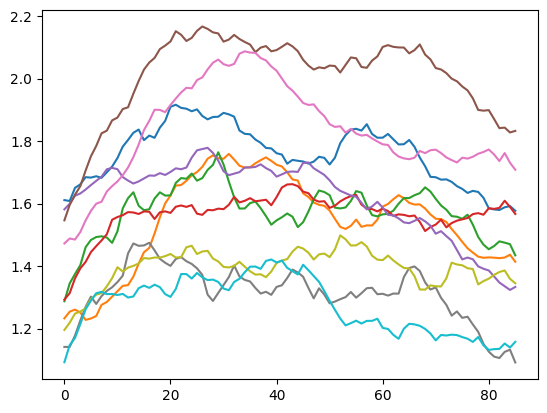

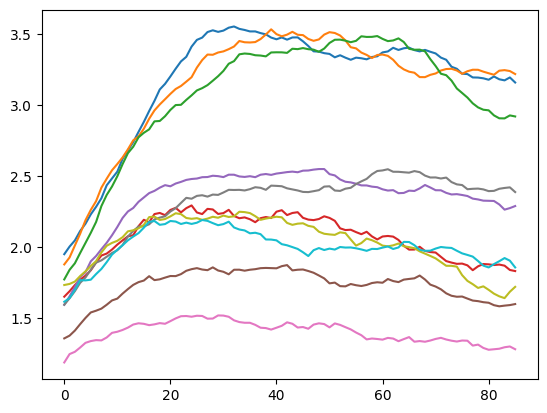

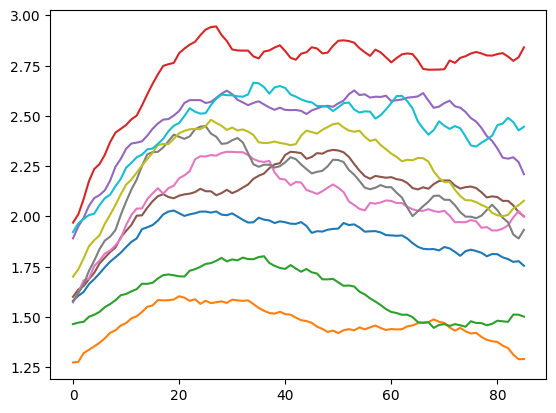

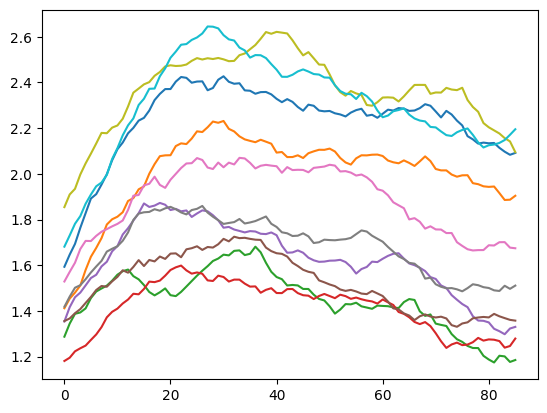

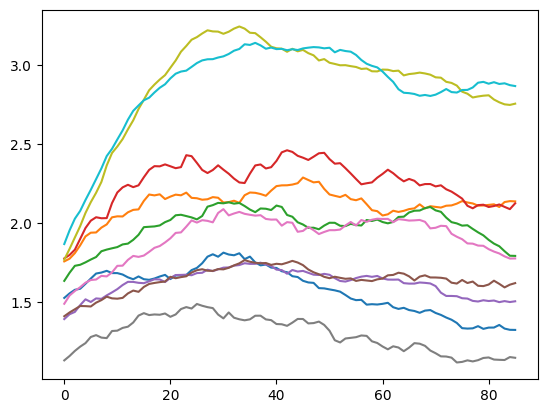

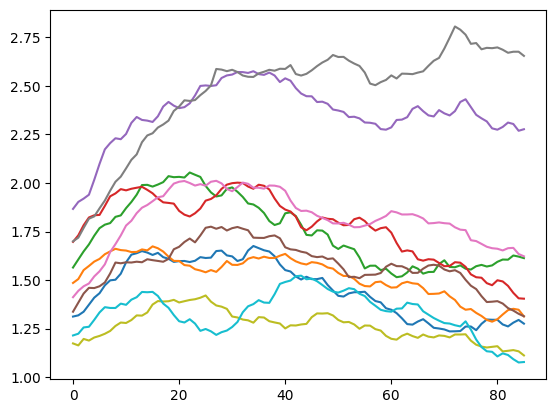

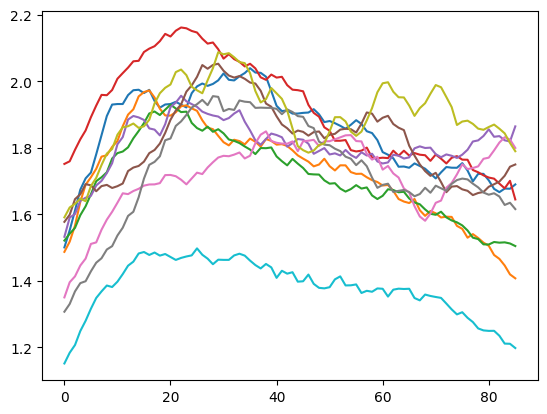

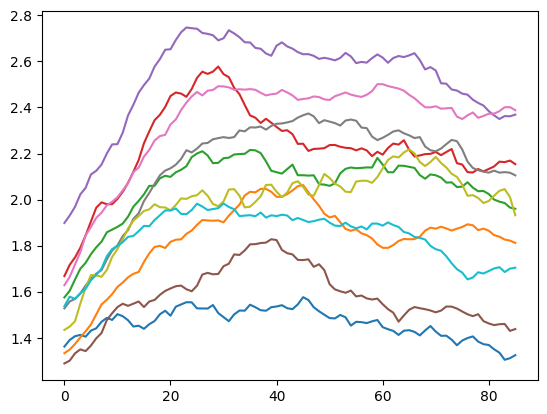

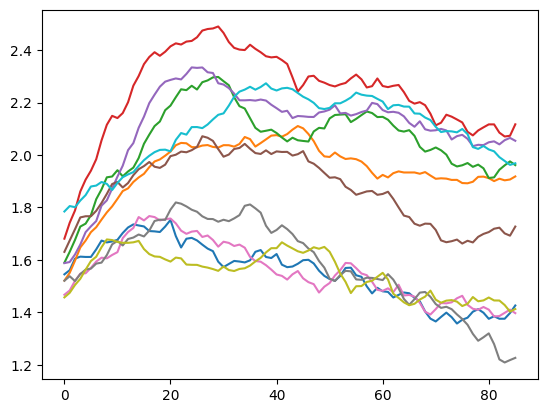

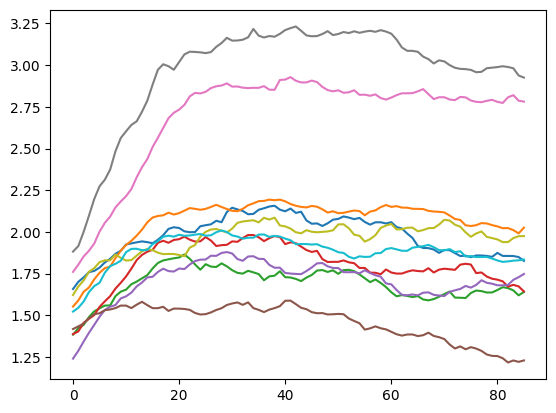

In [180]:
for i in range(10):
    plt.figure()
    plt.plot(gmt_smooth[i*10:(i+1)*10,:].T)
    plt.show()

In [ ]:
# trajectory without peak and decline: 
x_eoc = 1.8

### ref 
x     = np.arange(2015,2101,1)
x_gen = (np.array([2015,2100])-2015)
p     = np.polyfit(x_gen*0.08/(1+x_gen*0.08), 
                    [1,1.8],
                    deg = 1)
gmt_2 = p[0]*(x-2015)*0.075/(0.075*(x-2015)+1)+p[1]

### overshoot
p1    = np.polyfit([2015,2050,2085], 
                    [1,2.0,1],
                    deg = 2)
p2    = np.polyfit([2000,2050,2100], 
                    [1.8,2.0,1.8],
                    deg = 2)

gmt_3      = p1[0]*x**2+p1[1]*x+p1[2]
gmt_3[35:] = p2[0]*x[35:]**2+p2[1]*x[35:]+p2[2]

# compute impact for different temperatures: 
gmt_2_constructed = gmt_2+gmt_tmp[102,:]-gmt_smooth[102,:]
gmt_3_constructed = gmt_3+gmt_tmp[102,:]-gmt_smooth[102,:]

gmt_2_exc = (gmt_2_constructed[gmt_2_constructed>1.2]-1.2).sum()
gmt_2_uxc = -(gmt_2_constructed[gmt_2_constructed<1.2]-1.2).sum()
gmt_3_exc = (gmt_3_constructed[gmt_3_constructed>1.2]-1.2).sum()
gmt_3_uxc = -(gmt_3_constructed[gmt_3_constructed<1.2]-1.2).sum()


x_Ts      = np.arange(10,30.05,0.05)
impacts_2 = -(1-np.exp(gmt_2_exc*results_country_params[1]+gmt_2_exc*x_Ts*results_country_params[5]+gmt_2_uxc*results_country_params[2]+gmt_2_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100
impacts_3 = -(1-np.exp(gmt_3_exc*results_country_params[1]+gmt_3_exc*x_Ts*results_country_params[5]+gmt_3_uxc*results_country_params[2]+gmt_3_uxc*x_Ts*results_country_params[6]+x_eoc*results_country_params[3]))*100